## Making Movies

<a id='Data_Conditioning'></a>
* [Jump to Clean and Transform](#Clean_and_Transform)<br />
* [Jump to Question_1](#Question_1)<br />
* [Jump to Question_2](#Question_2)<br />
* [Jump to Question 3l](#Question_3)

# Data Conditioning

## Import necessary libraries

In [1]:
import os

import numpy as np
import pandas as pd

from glob import glob

In [2]:
# set the current working directory
os.chdir("c:/users/jd/flatiron/project01/dsc-mod-1-project-v2-1-online-ds-ft-120919/")

# print the current working directory
print(os.getcwd(), '\n')


c:\users\jd\flatiron\project01\dsc-mod-1-project-v2-1-online-ds-ft-120919 



## Inspect the file list

In [3]:
# get the list of files using glob
csv_files = glob("zippedData/*gz")

csv_files

['zippedData\\bom.movie_gross.csv.gz',
 'zippedData\\imdb.name.basics.csv.gz',
 'zippedData\\imdb.title.akas.csv.gz',
 'zippedData\\imdb.title.basics.csv.gz',
 'zippedData\\imdb.title.crew.csv.gz',
 'zippedData\\imdb.title.principals.csv.gz',
 'zippedData\\imdb.title.ratings.csv.gz',
 'zippedData\\rt.movie_info.tsv.gz',
 'zippedData\\rt.reviews.tsv.gz',
 'zippedData\\tmdb.movies.csv.gz',
 'zippedData\\tn.movie_budgets.csv.gz']

<h3 align='center'><font color='coral'>LOAD FILES AS DATAFRAMES</font></h3>

In [4]:
# create a dictionary with keys as csv/ tsv filename (cleaned)
# values as their respective dataframe names
csv_files_dict = {}

# populate the dictionary using a for loop
for filename in csv_files:
    # clean the file names
    filename_cleaned = os.path.basename(filename.replace(
    ".csv", "").replace(".tsv", "").replace(".gz", "").replace("-", "_").replace(".", "_"))
    if ".csv" in str(filename):
        filename_df = pd.read_csv(filename, compression='gzip', header=0, index_col=0)
    if ".tsv" in str(filename): # eg., `rt.movie_info.tsv`
        try:
            filename_df = pd.read_csv(
                filename, compression='gzip', sep="\t", index_col=0)
        except: # i.e., `rt.reviews.tsv`
            filename_df = pd.read_csv(
                filename, compression='gzip', sep="\t", encoding="latin-1", index_col=0)
    csv_files_dict[filename_cleaned] = filename_df #use cleaned file names
    # end loop

# view the created dictionaries keys (cleaned file names)
display(csv_files_dict.keys())

dict_keys(['bom_movie_gross', 'imdb_name_basics', 'imdb_title_akas', 'imdb_title_basics', 'imdb_title_crew', 'imdb_title_principals', 'imdb_title_ratings', 'rt_movie_info', 'rt_reviews', 'tmdb_movies', 'tn_movie_budgets'])

In [5]:
# test a dataframe from csv_files_dict
# assign it the variable `current_df`
# in the format: current_df = csv_files_dict[`df`]
current_df = csv_files_dict['imdb_title_basics']

# view only the current dataframe column names
display(current_df.iloc[:0,])


,primary_title,original_title,start_year,runtime_minutes,genres
tconst,,,,,


<h3 align='center'><font color='coral'>LOAD DATAFRAMES TO SQLITE DATABASE</font></h3>

## Load files into a sqlite database.

In [6]:
import sqlite3

In [7]:
# create a sqlite file in the current directory
conn = sqlite3.connect("movies_db.sqlite")

#### One-off example, to condition a nested dataframe into a sqlite table

In [8]:
# this converts a dataframe to a sqlite table, with the name 'tmdb_movies'
# enabling sql to create the schema

#csv_files_dict['tmdb_movies'].to_sql("tmdb_movies", conn)

### Create a function to automate this conversion

In [9]:
# Write a function that converts a nested dataframe to a sqlite table
def create_sql_table_from_df(df, name, conn):
    # Use try except
    # it will try to make a table
    # if a table exists the function will execute the except part
    try:
        df.to_sql(name, conn, if_exists='replace')
        print(f"Created table {name}")
    
    # if the table exists it replace it, and won't cause an error
    except Exception as e:
        print(f"could not make table {name}")
        print(e)

In [10]:
# Looping through the dictionary of keys and dataframes
# We can create the sql tables programmatically

for name, table in csv_files_dict.items():
    create_sql_table_from_df(table, name, conn)

Created table bom_movie_gross
Created table imdb_name_basics
Created table imdb_title_akas
Created table imdb_title_basics
Created table imdb_title_crew
Created table imdb_title_principals
Created table imdb_title_ratings
Created table rt_movie_info
Created table rt_reviews
Created table tmdb_movies
Created table tn_movie_budgets


In [11]:
# view names of all tables in the sql database
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('clean_bom_tbl',),
 ('clean_tn_tbl',),
 ('studio_titles_tbl',),
 ('clean_imdb_title_tbl',),
 ('bom_movie_gross',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rt_movie_info',),
 ('rt_reviews',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [12]:
# test query of a sql table
cur = conn.cursor()
print(cur.execute('''SELECT * FROM tn_movie_budgets LIMIT 2;''').fetchall())

[(1, 'Dec 18, 2009', 'Avatar', '$425,000,000', '$760,507,625', '$2,776,345,279'), (2, 'May 20, 2011', 'Pirates of the Caribbean: On Stranger Tides', '$410,600,000', '$241,063,875', '$1,045,663,875')]


In [13]:
# test query a sql table and wrap the results as a pandas dataframe
cur.execute('''SELECT * FROM rt_movie_info LIMIT 2;''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",None,None,104 minutes,None
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


## Add sqlite DB to a .gitignore file (file is too large to push to github)

In [14]:
# Now create a .gitignore file that will ignore unzipped and sqlite files
# files larger than 100 MB cannot be pushed to github from your computer

# create the file here in jupyter and open it from jupyter
with open("./.gitignore", "w+") as f:
    f.write("*.sqlite") # put files you want to ignore here
    f.write("\n") # insert a new line after each file
    f.write("zippedData/")
    f.write("\n")
    f.write("zippedData/*.csv")
    f.write("\n")
    f.write("zippedData/*.gz")

In [15]:
# closing the cursor and the connection
cur.close()
conn.close()

### All tables are now in the sqlite database `movies_db.sqlite` and accessible via pandas as dataframes.

### Continue to the Clean and Transform notebook

##### movies-clean-transform notebook
***

<a id='Clean_and_Transform'></a>
* [Jump to Data Conditioning](#Data_Conditioning)<br />
* [Jump to Question_1](#Question_1)<br />
* [Jump to Question_2](#Question_2)<br />
* [Jump to Question 3l](#Question_3)

<h1>Clean and Transform</h1>

### The purpose of this notebook is to:
    1. View data types
    2. Convert data types where needed
    3. Deal with missing values
    4. Inspect table relationships
    5. Potentially:
        a. Create derived values where advantageous
        b. Make initial joins
        c. Drop irrelevant tables

***

#### import required libraries

In [16]:
import os # for setting the current directory

import numpy as np
import pandas as pd

import sqlite3

import pandasql

In [17]:
# set the current working directory
os.chdir("c:/users/jd/flatiron/project01/dsc-mod-1-project-v2-1-online-ds-ft-120919/")

# print the current working directory
print(os.getcwd())

c:\users\jd\flatiron\project01\dsc-mod-1-project-v2-1-online-ds-ft-120919


#### connect to and preview sqlite database

In [18]:
# connect to sql movies_db data source and instantiate a cursor
conn = sqlite3.connect("movies_db.sqlite")
cur = conn.cursor()

#### import helper functions

In [19]:
from importlib import reload

import helper_functions as hf

In [20]:
# `helper_functions` includes `get_table_list(conn)`, 
# `load_table(conn, table_name)` and `convert_dollars_to_int(df, col)
# note: `get_table_list(conn)` result the same as the above `table_list`
reload(hf)

<module 'helper_functions' from 'c:\\users\\jd\\flatiron\\project01\\dsc-mod-1-project-v2-1-online-ds-ft-120919\\helper_functions.py'>

In [21]:
# function to preview all tables from sqlite_master
# or a sub - set entered as a list
def preview_tables(conn, tables='all'):
    all_tables = hf.get_table_list(conn)
    if tables=='all':
        final_table_names = all_tables
        
    elif type(tables) == list:
        final_table_names = [t for t in all_tables if t in tables]
    
    for table_name in final_table_names:
        print(f"Showing Table: {table_name}")
        query = f"select * from {table_name};"
        df = pd.read_sql(query, conn)
        display(df.head(2))
        display(df.info())
        print("-"*100)
    print("finished")
    return None

<h3 align='center'><font color='coral'>INSPECT TABLES AND DATA TYPES</font></h3>

In [22]:
preview_tables(conn)

Showing Table: clean_bom_tbl


,index,title,studio,domestic_gross,foreign_gross,year,Total_gross
0,0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 7 columns):
index             3382 non-null int64
title             3382 non-null object
studio            3382 non-null object
domestic_gross    3382 non-null float64
foreign_gross     2033 non-null float64
year              3382 non-null int64
Total_gross       2033 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 185.1+ KB


None

----------------------------------------------------------------------------------------------------
Showing Table: clean_tn_tbl


,index,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Year,ROI
0,0,1,2009-12-18 00:00:00,Avatar,425000000.0,760507625.0,2.776345e+09,2009,84.69
1,1,2,2011-05-20 00:00:00,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,60.73


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415 entries, 0 to 5414
Data columns (total 9 columns):
index                5415 non-null int64
id                   5415 non-null int64
release_date         5415 non-null object
movie                5415 non-null object
production_budget    5415 non-null float64
domestic_gross       5415 non-null float64
worldwide_gross      5415 non-null float64
Year                 5415 non-null object
ROI                  5415 non-null float64
dtypes: float64(4), int64(2), object(3)
memory usage: 380.9+ KB


None

----------------------------------------------------------------------------------------------------
Showing Table: studio_titles_tbl


,index,studio,title,Total_gross
0,0,bv,Black Panther,1.347000e+09
1,1,bv,Star Wars: The Last Jedi,1.332600e+09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 4 columns):
index          1064 non-null int64
studio         1064 non-null object
title          1064 non-null object
Total_gross    545 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 33.4+ KB


None

----------------------------------------------------------------------------------------------------
Showing Table: clean_imdb_title_tbl


,tconst,index,primary_title,original_title,start_year,runtime_minutes,genres,adventure,talk-show,adult,...,reality-tv,biography,short,romance,news,animation,drama,horror,history,game-show
0,tt0069049,2,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,tt0069204,3,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",0,0,0,...,0,0,0,0,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49462 entries, 0 to 49461
Data columns (total 34 columns):
tconst             49462 non-null object
index              49462 non-null int64
primary_title      49462 non-null object
original_title     49460 non-null object
start_year         49462 non-null int64
runtime_minutes    38549 non-null float64
genres             49462 non-null object
adventure          49462 non-null int64
talk-show          49462 non-null int64
adult              49462 non-null int64
thriller           49462 non-null int64
documentary        49462 non-null int64
fantasy            49462 non-null int64
crime              49462 non-null int64
mystery            49462 non-null int64
war                49462 non-null int64
sci-fi             49462 non-null int64
action             49462 non-null int64
family             49462 non-null int64
music              49462 non-null int64
sport              49462 non-null int64
comedy             49462 non-null int64
weste

None

----------------------------------------------------------------------------------------------------
Showing Table: bom_movie_gross


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


None

----------------------------------------------------------------------------------------------------
Showing Table: imdb_name_basics


,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
nconst                606648 non-null object
primary_name          606648 non-null object
birth_year            82736 non-null float64
death_year            6783 non-null float64
primary_profession    555308 non-null object
known_for_titles      576444 non-null object
dtypes: float64(2), object(4)
memory usage: 27.8+ MB


None

----------------------------------------------------------------------------------------------------
Showing Table: imdb_title_akas


,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
title_id             331703 non-null object
ordering             331703 non-null int64
title                331703 non-null object
region               278410 non-null object
language             41715 non-null object
types                168447 non-null object
attributes           14925 non-null object
is_original_title    331678 non-null float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


None

----------------------------------------------------------------------------------------------------
Showing Table: imdb_title_basics


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
tconst             146144 non-null object
primary_title      146144 non-null object
original_title     146123 non-null object
start_year         146144 non-null int64
runtime_minutes    114405 non-null float64
genres             140736 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


None

----------------------------------------------------------------------------------------------------
Showing Table: imdb_title_crew


,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,None,"nm0175726,nm1802864"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
tconst       146144 non-null object
directors    140417 non-null object
writers      110261 non-null object
dtypes: object(3)
memory usage: 3.3+ MB


None

----------------------------------------------------------------------------------------------------
Showing Table: imdb_title_principals


,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
tconst        1028186 non-null object
ordering      1028186 non-null int64
nconst        1028186 non-null object
category      1028186 non-null object
job           177684 non-null object
characters    393360 non-null object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


None

----------------------------------------------------------------------------------------------------
Showing Table: imdb_title_ratings


,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
tconst           73856 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


None

----------------------------------------------------------------------------------------------------
Showing Table: rt_movie_info


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",None,None,104 minutes,None
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
id              1560 non-null int64
synopsis        1498 non-null object
rating          1557 non-null object
genre           1552 non-null object
director        1361 non-null object
writer          1111 non-null object
theater_date    1201 non-null object
dvd_date        1201 non-null object
currency        340 non-null object
box_office      340 non-null object
runtime         1530 non-null object
studio          494 non-null object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


None

----------------------------------------------------------------------------------------------------
Showing Table: rt_reviews


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,None,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
id            54432 non-null int64
review        48869 non-null object
rating        40915 non-null object
fresh         54432 non-null object
critic        51710 non-null object
top_critic    54432 non-null int64
publisher     54123 non-null object
date          54432 non-null object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


None

----------------------------------------------------------------------------------------------------
Showing Table: tmdb_movies


,index,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
index                26517 non-null int64
genre_ids            26517 non-null object
id                   26517 non-null int64
original_language    26517 non-null object
original_title       26517 non-null object
popularity           26517 non-null float64
release_date         26517 non-null object
title                26517 non-null object
vote_average         26517 non-null float64
vote_count           26517 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


None

----------------------------------------------------------------------------------------------------
Showing Table: tn_movie_budgets


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

----------------------------------------------------------------------------------------------------
finished


#### Preview suggests columns of interest (based on our questions) regarding box office performance for titles, studios, and genres
   
    >  `bom_movie_gross`: ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']
    >  `tn_movie_budgets`: ['release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']
    >  `imdb_title_basics`: ['primary_title', 'start_year', 'genres']
    >  `rt_movie_info`: ['genre', 'theater_date', 'currency', 'box_office']    

#### Cleaning Notes:
* bom_movie_gross | 'domestic_gross' is a REAL number, while 'foreign_gross' is TEXT; table has no foreign keys (unless title names match)
* tn_movie_budgets | 'production_budget', 'domestic_gross', and 'worldwide_gross' are each TEXT
* imdb_title_basics | 'genres' values are "," separated
* rt_movie_info | 'box_office' is TEXT; 'genre' values are "|" separated
* all "*date*" values are text, while "*year*" values are of type INTEGER

#### We will review and clean these tables. in turn, below.

<h2 align='center'><font color='chocolate'>SEQUENTIALLY REVIEW, CLEAN, AND TRANSFORM</font></h2>

### bom_movie_gross

In [23]:
preview_tables(conn, ['bom_movie_gross'])

Showing Table: bom_movie_gross


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


None

----------------------------------------------------------------------------------------------------
finished


### Connect `bom_movie_gross`

In [24]:
# connect to the table and view in pandas for cleaning
cur.execute('''SELECT *
                    FROM bom_movie_gross
                    ;''')

clean_bom_df = pd.DataFrame(cur.fetchall())
clean_bom_df.columns = [x[0] for x in cur.description]
display(clean_bom_df.dtypes)
clean_bom_df.head(3)

title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


### Convert  `clean_bom_df`

#### Change `foreign_gross` data type to match `domestic_gross`

In [25]:
# convert `foreign_gross` to remove commas and to match `domestic_gross` data type
clean_bom_df['foreign_gross'] = clean_bom_df['foreign_gross'].str.replace(',', '').astype(float)

# add a `Total_gross` column for EDA
clean_bom_df['Total_gross'] = clean_bom_df['domestic_gross'] + clean_bom_df['foreign_gross']

# and view a sample
clean_bom_df.loc[clean_bom_df.title == 'Alice in Wonderland (2010)', :]

,title,studio,domestic_gross,foreign_gross,year,Total_gross
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09


In [26]:
clean_bom_df.info()
# data type converted and column added
# let's check for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 6 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null float64
year              3387 non-null int64
Total_gross       2009 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 158.9+ KB


In [27]:
# we have null values--first drop where all values are null...
clean_bom_df.dropna(how = 'all')
clean_bom_df.info()

# no change--no rows with null values across the board

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 6 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null float64
year              3387 non-null int64
Total_gross       2009 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 158.9+ KB


In [28]:
# and create a function to count where we still have them
def null_count(s):
    null_columns=s.columns[s.isnull().any()]
    return s[null_columns].isnull().sum()

In [29]:
display(null_count(clean_bom_df))

# also preview rows where domestic_gross is null and where `studio` is null
display(clean_bom_df[pd.notnull(clean_bom_df['domestic_gross']) != True].sort_values(by='year'))
display(clean_bom_df[pd.notnull(clean_bom_df['studio']) != True].sort_values(by='year'))

# we can drop rows for movies without a studio
# and change 'gross' series nulls to 0

studio               5
domestic_gross      28
foreign_gross     1350
Total_gross       1378
dtype: int64

,title,studio,domestic_gross,foreign_gross,year,Total_gross
230,It's a Wonderful Afterlife,UTV,NaN,1300000.0,2010,NaN
298,Celine: Through the Eyes of the World,Sony,NaN,119000.0,2010,NaN
302,White Lion,Scre.,NaN,99600.0,2010,NaN
306,Badmaash Company,Yash,NaN,64400.0,2010,NaN
327,Aashayein (Wishes),Relbig.,NaN,3800.0,2010,NaN
537,Force,FoxS,NaN,4800000.0,2011,NaN
713,Empire of Silver,NeoC,NaN,19000.0,2011,NaN
1017,Dark Tide,WHE,NaN,432000.0,2012,NaN
966,The Cup (2012),Myr.,NaN,1800000.0,2012,NaN
936,"Lula, Son of Brazil",NYer,NaN,3800000.0,2012,NaN


,title,studio,domestic_gross,foreign_gross,year,Total_gross
210,Outside the Law (Hors-la-loi),None,96900.0,3300000.0,2010,3396900.0
555,Fireflies in the Garden,None,70600.0,3300000.0,2011,3370600.0
933,Keith Lemon: The Film,None,NaN,4000000.0,2012,NaN
1862,Plot for Peace,None,7100.0,NaN,2014,NaN
2825,Secret Superstar,None,NaN,122000000.0,2017,NaN


In [30]:
# drop null `studio` rows (if we can drop 'None' values)
clean_bom_df.dropna(subset=['studio'], inplace=True)
display(clean_bom_df[pd.notnull(clean_bom_df['studio']) != True])

,title,studio,domestic_gross,foreign_gross,year,Total_gross


In [31]:
# ...and for `domestic_gross` nulls
clean_bom_df.domestic_gross.fillna(0, inplace=True)

# check with the same line we used to view nulls above
display(clean_bom_df[pd.notnull(clean_bom_df['domestic_gross']) != True].sort_values(by='year'))

,title,studio,domestic_gross,foreign_gross,year,Total_gross


In [32]:
# sanity check
null_count(clean_bom_df)

foreign_gross    1349
Total_gross      1375
dtype: int64

In [33]:
#  create a function to replace series null values with 0
# def fill_na_zeroes(series):
#     series.fillna(0)
#     print("-+-+-+-+-+-Null values replaced with '0'.-+-+-+-+-+-")

In [34]:
# fill_na_zeroes(clean_bom_df.domestic_gross)
# fill_na_zeroes(clean_bom_df.foreign_gross)

# display(clean_bom_df.domestic_gross.isna().value_counts(), clean_bom_df.foreign_gross.isna().value_counts())

In [35]:
# It looks like we need to re-calculate the `Total_gross` column
clean_bom_df[clean_bom_df['title'] == "Empire of Silver"]

,title,studio,domestic_gross,foreign_gross,year,Total_gross
713,Empire of Silver,NeoC,0.0,19000.0,2011,NaN


In [36]:
# update `Total_gross` column for EDA
clean_bom_df['Total_gross'] = clean_bom_df['domestic_gross'] + clean_bom_df['foreign_gross']

# and view a sample
clean_bom_df[clean_bom_df['title'] == "Empire of Silver"]

,title,studio,domestic_gross,foreign_gross,year,Total_gross
713,Empire of Silver,NeoC,0.0,19000.0,2011,19000.0


### Add `clean_bom_df` to sqlite

In [37]:
# add the new df as a table to the sqlite database
clean_bom_df.to_sql('clean_bom_tbl', conn, if_exists='replace')

# view names of all tables in the sql database to verify operation
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('clean_tn_tbl',),
 ('studio_titles_tbl',),
 ('clean_imdb_title_tbl',),
 ('bom_movie_gross',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rt_movie_info',),
 ('rt_reviews',),
 ('tmdb_movies',),
 ('tn_movie_budgets',),
 ('clean_bom_tbl',)]

### tn_movie_budgets

In [38]:
preview_tables(conn, ['tn_movie_budgets'])

Showing Table: tn_movie_budgets


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

----------------------------------------------------------------------------------------------------
finished


### Connect `tn_movie_budgets`

In [39]:
# connect to the table and view in pandas for cleaning
cur.execute('''SELECT *
                    FROM tn_movie_budgets
                    ;''')

clean_tn_budgets_df = pd.DataFrame(cur.fetchall())
clean_tn_budgets_df.columns = [x[0] for x in cur.description]
display(clean_tn_budgets_df.dtypes)
clean_tn_budgets_df.head(3)

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


### Convert

In [40]:
# convert date
clean_tn_budgets_df.release_date = pd.to_datetime(clean_tn_budgets_df.release_date)
clean_tn_budgets_df['Year'] = clean_tn_budgets_df.release_date.map(lambda x: x.strftime('%Y'))
clean_tn_budgets_df.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Year
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009


#### Our preview indicated no null values, but we do have some cleaning to do.
* We need large integer data types for the budget and gross fields.
* Symbols and separators must be removed.  Method chaining helps to keep the operation efficient.

In [41]:
# `convert_dollars_to_int(df, col)` accepts a dataframe and a column
# encountered errors
# we can quickly pass each of the necessary args via a loop

for col in clean_tn_budgets_df.columns[3:6]:
    clean_tn_budgets_df[col] = clean_tn_budgets_df[col].str.replace("$", "").str.replace(",", "").astype('float64')

clean_tn_budgets_df.dtypes

id                            int64
release_date         datetime64[ns]
movie                        object
production_budget           float64
domestic_gross              float64
worldwide_gross             float64
Year                         object
dtype: object

In [42]:
# view the top - ten in order of `worldwide_gross`
display(clean_tn_budgets_df.head(10).sort_values(by=['worldwide_gross'], ascending=False))

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Year
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,2015
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2018
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011
7,8,2007-05-24,Pirates of the Caribbean: At Worldâs End,300000000.0,309420425.0,9.634204e+08,2007
9,10,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08,2015
8,9,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,2017
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019


In [43]:
# add a column to display return on investment (ROI)
clean_tn_budgets_df['ROI'] = round((
    (clean_tn_budgets_df['worldwide_gross'] - clean_tn_budgets_df["production_budget"]
    ) / clean_tn_budgets_df['worldwide_gross']) * 100, 2).astype('float64')

display(clean_tn_budgets_df.dtypes)
clean_tn_budgets_df.head(3)

id                            int64
release_date         datetime64[ns]
movie                        object
production_budget           float64
domestic_gross              float64
worldwide_gross             float64
Year                         object
ROI                         float64
dtype: object

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Year,ROI
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009,84.69
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,60.73
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,-133.70


#### Eliminate rows with `-inf` values in ROI


In [44]:
display(clean_tn_budgets_df.loc[clean_tn_budgets_df.worldwide_gross == 0].head(2))

# Get names of indexes for which column `worldwide_gross` has value 0
index_names = clean_tn_budgets_df[ clean_tn_budgets_df['worldwide_gross'] == 0 ].index

# Delete these row indexes from dataFrame
clean_tn_budgets_df.drop(index_names , inplace=True)

clean_tn_budgets_df.loc[clean_tn_budgets_df.worldwide_gross == 0]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Year,ROI
194,95,2020-12-31,Moonfall,150000000.0,0.0,0.0,2020,-inf
479,80,2017-12-13,Bright,90000000.0,0.0,0.0,2017,-inf


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Year,ROI


### Add `clean_tn_budgets_df` to sqlite

In [45]:
# add the new df as a table to the sqlite database
clean_tn_budgets_df.to_sql('clean_tn_tbl', conn, if_exists='replace')

# view names of all tables in the sql database to verify operation
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('studio_titles_tbl',),
 ('clean_imdb_title_tbl',),
 ('bom_movie_gross',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rt_movie_info',),
 ('rt_reviews',),
 ('tmdb_movies',),
 ('tn_movie_budgets',),
 ('clean_bom_tbl',),
 ('clean_tn_tbl',)]

### imdb_title_basics

In [46]:
preview_tables(conn, ['imdb_title_basics'])

Showing Table: imdb_title_basics


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
tconst             146144 non-null object
primary_title      146144 non-null object
original_title     146123 non-null object
start_year         146144 non-null int64
runtime_minutes    114405 non-null float64
genres             140736 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


None

----------------------------------------------------------------------------------------------------
finished


### Connect `imdb_title_basics`

In [47]:
# connect to the table and view in pandas for cleaning
cur.execute('''SELECT *
                    FROM imdb_title_basics
                    ;''')

clean_imdb_title_df = pd.DataFrame(cur.fetchall())
clean_imdb_title_df.columns = [x[0] for x in cur.description]
display(clean_imdb_title_df.dtypes)
clean_imdb_title_df.head(3)

tconst              object
primary_title       object
original_title      object
start_year           int64
runtime_minutes    float64
genres              object
dtype: object

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


### Extract and expand `clean_imdb_title_df` genres

In [48]:
clean_imdb_title_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [49]:
# turning generes into columns
all_genres = set()
for genre in clean_imdb_title_df['genres']:
    try:
        genres = genre.lower().split(",")
        all_genres.update(genres)
    except:
        continue
    
all_genres

{'action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western'}

In [50]:
"""
Create a dictionary with `all_genres` elements as keys,
iterate through series to create a same - length boolean list
stating whether the current genre is present in the current row.
Append the key, boolean list pair to the dict.
"""

genres_dict = {}
for genre in all_genres:
    has_genre = []
    for g in clean_imdb_title_df['genres']:
        has_genre.append(False if not g else genre in g.lower())
    genres_dict[genre] = has_genre
    
genres_dict

{'family': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  F

In [51]:
"""append genre_list keys as columns, values as
row values to `clean_imdb_title_df`"""
for genre, has_genre in genres_dict.items():
    clean_imdb_title_df[genre] = has_genre

In [52]:
# preview the result
pd.set_option('display.max_columns', None)
clean_imdb_title_df[clean_imdb_title_df.start_year >= 2016][:5]

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,family,music,crime,talk-show,reality-tv,comedy,western,documentary,history,fantasy,sci-fi,sport,mystery,adventure,musical,animation,drama,short,adult,romance,action,war,news,thriller,biography,game-show,horror
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### Add `imdb_title_basics` to sqlite

In [53]:
# add the new df as a table to the sqlite database
clean_imdb_title_df.to_sql('clean_imdb_title_tbl', conn, if_exists='replace')

# view names of all tables in the sql database to verify operation
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('studio_titles_tbl',),
 ('bom_movie_gross',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rt_movie_info',),
 ('rt_reviews',),
 ('tmdb_movies',),
 ('tn_movie_budgets',),
 ('clean_bom_tbl',),
 ('clean_tn_tbl',),
 ('clean_imdb_title_tbl',)]

### `rt_movie_info`

In [54]:
preview_tables(conn, ['rt_movie_info'])

Showing Table: rt_movie_info


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",None,None,104 minutes,None
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
id              1560 non-null int64
synopsis        1498 non-null object
rating          1557 non-null object
genre           1552 non-null object
director        1361 non-null object
writer          1111 non-null object
theater_date    1201 non-null object
dvd_date        1201 non-null object
currency        340 non-null object
box_office      340 non-null object
runtime         1530 non-null object
studio          494 non-null object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


None

----------------------------------------------------------------------------------------------------
finished


### Connect `rt_movie_info`

In [55]:
# connect to the table and view in pandas for cleaning
cur.execute('''SELECT *
                    FROM rt_movie_info
                    ;''')

clean_rt_info_df = pd.DataFrame(cur.fetchall())
clean_rt_info_df.columns = [x[0] for x in cur.description]
display(clean_rt_info_df.dtypes)
clean_rt_info_df.head(3)

id               int64
synopsis        object
rating          object
genre           object
director        object
writer          object
theater_date    object
dvd_date        object
currency        object
box_office      object
runtime         object
studio          object
dtype: object

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",None,None,104 minutes,None
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",None,None,116 minutes,None


In [56]:
# let's see what shape the dataframe is in
print("rows and columns:", clean_rt_info_df.shape)

# how many values are missing
print("number of 'box_office' missing values:", clean_rt_info_df['box_office'].isna().sum())

# we may as well take a deeper look while we're at it
display(clean_rt_info_df.head(5).sort_values(by=['box_office'], ascending=False))

rows and columns: (1560, 12)
number of 'box_office' missing values: 1220


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",None,None,104 minutes,None
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",None,None,116 minutes,None
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",None,None,128 minutes,None
4,7,None,NR,Drama|Romance,Rodney Bennett,Giles Cooper,None,None,None,None,200 minutes,None


#### Whoa! That's a <i>rotten</i> number of missing values. And where are the movie titles?
#### This dataframe may have been helpful with genre categories, but we already have those. 

### Disregard `clean_rt_info_df`

### `tmdb_movies`

In [57]:
preview_tables(conn, ['tmdb_movies'])

Showing Table: tmdb_movies


,index,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
index                26517 non-null int64
genre_ids            26517 non-null object
id                   26517 non-null int64
original_language    26517 non-null object
original_title       26517 non-null object
popularity           26517 non-null float64
release_date         26517 non-null object
title                26517 non-null object
vote_average         26517 non-null float64
vote_count           26517 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


None

----------------------------------------------------------------------------------------------------
finished


### This table appear well populated, but it provides no new useful information for our investigation.

### Disregard `tmdb_movies`

***

<h2 align='center'><font color='chocolate'>DROP UNUSED AND UN-CLEANED TABLES FROM SQLITE DATABASE</font></h2>

<h3>Original data is still available in the csv files</h3>

   
* Cleaned:
    `clean_tn_tbl`
    `clean_bom_tbl`
    `clean_imdb_tbl`

<h3>Tables to remove</h3>    

* To drop:

     `bom_movie_gross`
     `imdb_name_basics`
     `imdb_title_akas`
     `imdb_title_basics`
     `imdb_title_crew`
     `imdb_title_principals`
     `imdb_title_ratings`
     `rt_movie_info`
     `rt_reviews`
     `tmdb_movies`
     `tn_movie_budgets`

     

In [58]:
# Execute the DROP Table SQL statement
 
dropTableStatement = "DROP TABLE bom_movie_gross"
cur.execute(dropTableStatement)

dropTableStatement = "DROP TABLE imdb_name_basics "
cur.execute(dropTableStatement)
 
dropTableStatement = "DROP TABLE imdb_title_akas"
cur.execute(dropTableStatement)

dropTableStatement = "DROP TABLE imdb_title_basics "
cur.execute(dropTableStatement)
 
dropTableStatement = "DROP TABLE imdb_title_crew"
cur.execute(dropTableStatement)
 
dropTableStatement = "DROP TABLE imdb_title_principals"
cur.execute(dropTableStatement)
 
dropTableStatement = "DROP TABLE imdb_title_ratings"
cur.execute(dropTableStatement)

dropTableStatement = "DROP TABLE rt_movie_info"
cur.execute(dropTableStatement)

dropTableStatement = "DROP TABLE rt_reviews"
cur.execute(dropTableStatement)
 
dropTableStatement = "DROP TABLE tmdb_movies"
cur.execute(dropTableStatement)
 
dropTableStatement = "DROP TABLE tn_movie_budgets"
cur.execute(dropTableStatement)

preview_tables(conn, tables='all')


Showing Table: studio_titles_tbl


,index,studio,title,Total_gross
0,0,bv,Black Panther,1.347000e+09
1,1,bv,Star Wars: The Last Jedi,1.332600e+09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 4 columns):
index          1064 non-null int64
studio         1064 non-null object
title          1064 non-null object
Total_gross    545 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 33.4+ KB


None

----------------------------------------------------------------------------------------------------
Showing Table: clean_bom_tbl


,index,title,studio,domestic_gross,foreign_gross,year,Total_gross
0,0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 7 columns):
index             3382 non-null int64
title             3382 non-null object
studio            3382 non-null object
domestic_gross    3382 non-null float64
foreign_gross     2033 non-null float64
year              3382 non-null int64
Total_gross       2033 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 185.1+ KB


None

----------------------------------------------------------------------------------------------------
Showing Table: clean_tn_tbl


,index,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Year,ROI
0,0,1,2009-12-18 00:00:00,Avatar,425000000.0,760507625.0,2.776345e+09,2009,84.69
1,1,2,2011-05-20 00:00:00,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,60.73


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415 entries, 0 to 5414
Data columns (total 9 columns):
index                5415 non-null int64
id                   5415 non-null int64
release_date         5415 non-null object
movie                5415 non-null object
production_budget    5415 non-null float64
domestic_gross       5415 non-null float64
worldwide_gross      5415 non-null float64
Year                 5415 non-null object
ROI                  5415 non-null float64
dtypes: float64(4), int64(2), object(3)
memory usage: 380.9+ KB


None

----------------------------------------------------------------------------------------------------
Showing Table: clean_imdb_title_tbl


,index,tconst,primary_title,original_title,start_year,runtime_minutes,genres,family,music,crime,talk-show,reality-tv,comedy,western,documentary,history,fantasy,sci-fi,sport,mystery,adventure,musical,animation,drama,short,adult,romance,action,war,news,thriller,biography,game-show,horror
0,0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 34 columns):
index              146144 non-null int64
tconst             146144 non-null object
primary_title      146144 non-null object
original_title     146123 non-null object
start_year         146144 non-null int64
runtime_minutes    114405 non-null float64
genres             140736 non-null object
family             146144 non-null int64
music              146144 non-null int64
crime              146144 non-null int64
talk-show          146144 non-null int64
reality-tv         146144 non-null int64
comedy             146144 non-null int64
western            146144 non-null int64
documentary        146144 non-null int64
history            146144 non-null int64
fantasy            146144 non-null int64
sci-fi             146144 non-null int64
sport              146144 non-null int64
mystery            146144 non-null int64
adventure          146144 non-null int64
musical            146

None

----------------------------------------------------------------------------------------------------
finished


In [59]:
# Close the connection object
# connection.close()

## Continue to Question Notebooks

In [60]:
cur.close()
conn.close()

##### movies-q1 notebook
***

<h1>Question 1 - What are the highest grossing, recent movies?</h1>

<a id='Question_1'></a>
* [Jump to Data Conditioning](#Data_Conditioning)<br />
* [Jump to Clean and Transform](#Clean_and_Transform)<br />
* [Jump to Question_2](#Question_2)<br />
* [Jump to Question 3](#Question_3)

### Let's set the scene and explore our first question:
    1. How does the industry look?
    2. What are the top grossing movies for the most recent, full year?
    3. What are the top grossing movies, including the additional 2 years prior?

## import required libraries

In [61]:
import os # for setting the current directory

import numpy as np
import pandas as pd

import sqlite3
import pandasql

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [62]:
# set the current working directory
os.chdir("c:/users/jd/flatiron/project01/dsc-mod-1-project-v2-1-online-ds-ft-120919/")

# print the current working directory
print(os.getcwd())

c:\users\jd\flatiron\project01\dsc-mod-1-project-v2-1-online-ds-ft-120919


### connect to sqlite database

In [63]:
# connect to sql movies_db data source and instantiate a cursor
conn = sqlite3.connect("movies_db.sqlite")
cur = conn.cursor()

### list the sqlite table names

In [64]:
# get names of all tables in the sql database
sql_tables = conn.execute("select name from sqlite_master where type='table';")

# assign table names to a variable as a list for future iteration
table_list = list(map(lambda x: x[0], sql_tables.fetchall()))
table_list

['studio_titles_tbl', 'clean_bom_tbl', 'clean_tn_tbl', 'clean_imdb_title_tbl']

***

<h2 align='center'><font color='chocolate'>Highest grossing movies</font></h2>

In [65]:
# connect to the required tables
cur.execute('''SELECT *
                    FROM clean_bom_tbl
                    ;''')

bom_df = pd.DataFrame(cur.fetchall())
bom_df.columns = [x[0] for x in cur.description]
bom_df.head(5)

,index,title,studio,domestic_gross,foreign_gross,year,Total_gross
0,0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08
3,3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08
4,4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08


In [66]:
# what were the top 10 highest - gross movies in 2018
bom_2018_df = bom_df.loc[bom_df.year == 2018]
display(bom_2018_df.sort_values(by=['Total_gross'], ascending=False).head(10))

#2016 - 2018
bom_2016_18_df = bom_df.loc[bom_df.year.between (2016, 2018)]
display(bom_2016_18_df.sort_values(by=['Total_gross'], ascending=False).head(10))

,index,title,studio,domestic_gross,foreign_gross,year,Total_gross
3075,3080,Black Panther,BV,700100000.0,646900000.0,2018,1.347000e+09
3076,3081,Jurassic World: Fallen Kingdom,Uni.,417700000.0,891800000.0,2018,1.309500e+09
3077,3082,Incredibles 2,BV,608600000.0,634200000.0,2018,1.242800e+09
3078,3083,Aquaman,WB,335100000.0,812700000.0,2018,1.147800e+09
3079,3084,Bohemian Rhapsody,Fox,216400000.0,687200000.0,2018,9.036000e+08
3080,3085,Venom (2018),Sony,213500000.0,641500000.0,2018,8.550000e+08
3081,3086,Mission: Impossible - Fallout,Par.,220200000.0,571000000.0,2018,7.912000e+08
3082,3087,Deadpool 2,Fox,318500000.0,460500000.0,2018,7.790000e+08
3074,3079,Avengers: Infinity War,BV,678800000.0,1369.5,2018,6.788014e+08
3083,3088,Fantastic Beasts: The Crimes of Grindelwald,WB,159600000.0,494100000.0,2018,6.537000e+08


,index,title,studio,domestic_gross,foreign_gross,year,Total_gross
3075,3080,Black Panther,BV,700100000.0,646900000.0,2018,1.347000e+09
2754,2758,Star Wars: The Last Jedi,BV,620200000.0,712400000.0,2017,1.332600e+09
3076,3081,Jurassic World: Fallen Kingdom,Uni.,417700000.0,891800000.0,2018,1.309500e+09
2755,2759,Beauty and the Beast (2017),BV,504000000.0,759500000.0,2017,1.263500e+09
3077,3082,Incredibles 2,BV,608600000.0,634200000.0,2018,1.242800e+09
2318,2322,Captain America: Civil War,BV,408100000.0,745200000.0,2016,1.153300e+09
3078,3083,Aquaman,WB,335100000.0,812700000.0,2018,1.147800e+09
2319,2323,Rogue One: A Star Wars Story,BV,532200000.0,523900000.0,2016,1.056100e+09
2757,2761,Despicable Me 3,Uni.,264600000.0,770200000.0,2017,1.034800e+09
2320,2324,Finding Dory,BV,486300000.0,542300000.0,2016,1.028600e+09


### Even before visual EDA the data is beginning to tell a story re. action/ adventure, sequels, franchises, remakes, and animation.

In [67]:
# connect to the table for 2018
cur.execute('''SELECT *
                    FROM clean_bom_tbl
                    WHERE year == 2018
                    ORDER BY Total_gross DESC
                    LIMIT 10
                    ;''')

bom_18_title_10_df = pd.DataFrame(cur.fetchall())
bom_18_title_10_df.columns = [x[0] for x in cur.description]

In [68]:
# connect to the table for 2016-2018
cur.execute('''SELECT *
                    FROM clean_bom_tbl
                    WHERE year BETWEEN 2016 AND 2018
                    ORDER BY Total_gross DESC
                    LIMIT 10
                    ;''')

bom_16_18_title_10_df = pd.DataFrame(cur.fetchall())
bom_16_18_title_10_df.columns = [x[0] for x in cur.description]

<h2 align='center'><font color='coral'>Visual EDA</font></h2>

#### What can we learn from visualizing these dataframes?

In [69]:
# initialize a variable
df_0 = bom_18_title_10_df
df_0.set_index("title", drop=True,inplace=True)
df_0.head(1)

,index,studio,domestic_gross,foreign_gross,year,Total_gross
title,,,,,,
Black Panther,3080,BV,700100000.0,646900000.0,2018,1.347000e+09


In [70]:
df_1 = bom_16_18_title_10_df
df_1.set_index("title", drop=True,inplace=True)

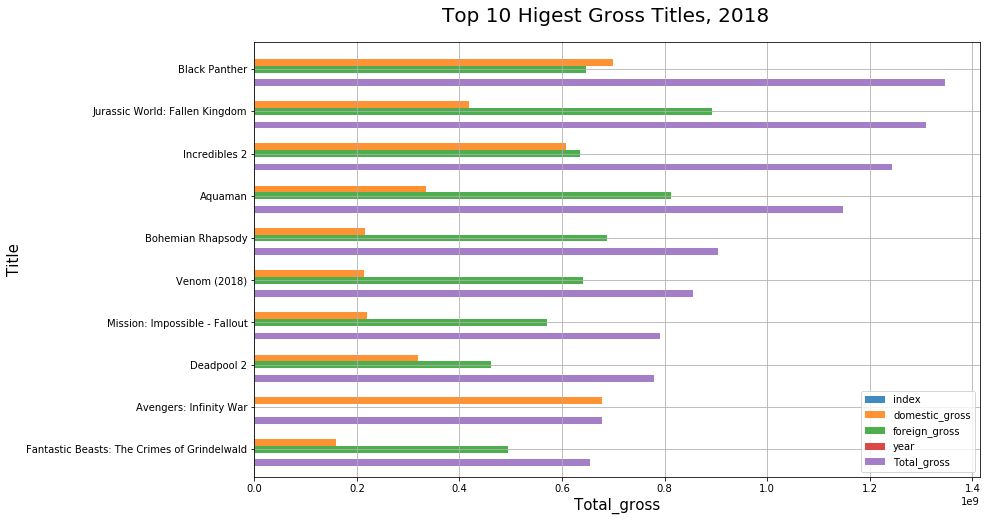

In [71]:
# plot 2018 data horizontally
df_0.plot( kind='barh', figsize=(13,8), grid=True, alpha=.85, width=.8 )
plt.style.use('seaborn-muted')

plt.suptitle('Top 10 Higest Gross Titles, 2018', fontsize=20, y=.94)
plt.xlabel('Total_gross', fontsize=15)
plt.ylabel('Title', fontsize=15)
plt.ylim(plt.ylim()[::-1]) # display with highes grossing title on top

plt.show()

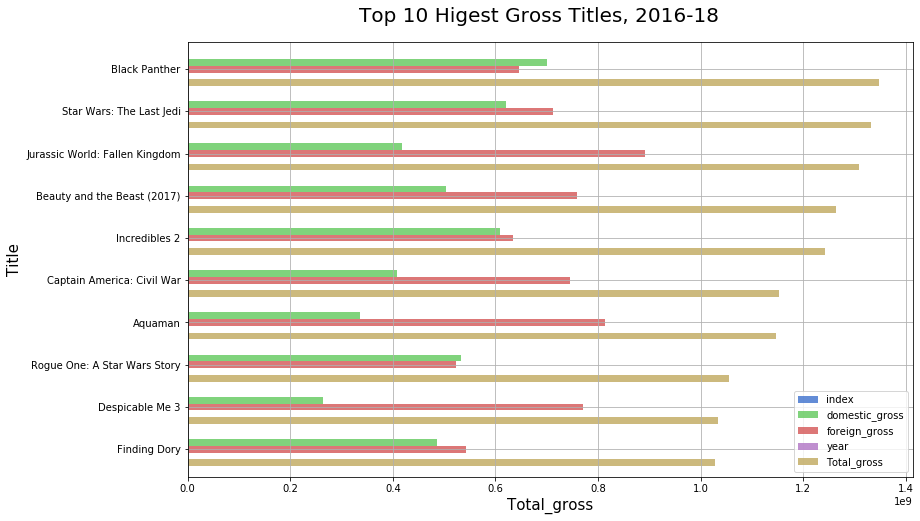

In [72]:
# plot 2016-18 data horizontally
df_1.plot( kind='barh', figsize=(13,8), grid=True, alpha=.85, width=.8 )
plt.style.use('seaborn-muted')

plt.suptitle('Top 10 Higest Gross Titles, 2016-18', fontsize=20, y=.94)
plt.xlabel('Total_gross', fontsize=15)
plt.ylabel('Title', fontsize=15)
plt.ylim(plt.ylim()[::-1]) # display with highes grossing title on top

plt.show()

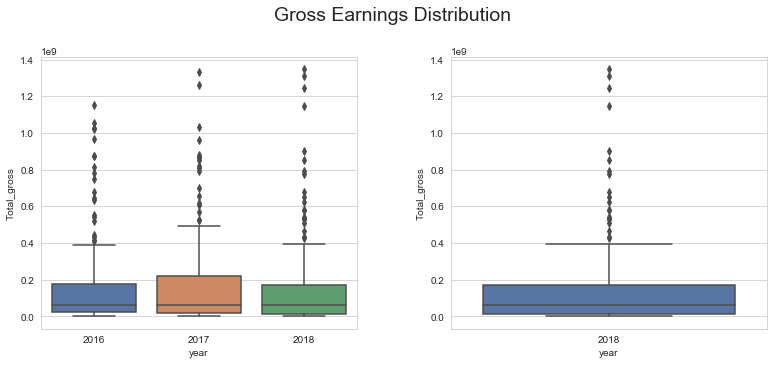

In [73]:
# viewing the three most recent years from the dataset
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
sns.set(context='notebook', font_scale=1.35)

# give a little more space between the 'suptitle' and fiugre
fig.suptitle("Gross Earnings Distribution", y=1.02)
# and between subplots
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.3, hspace=None)

sns.boxplot(x="year", y="Total_gross", data=bom_2016_18_df, ax=ax[0])
sns.boxplot(x="year", y="Total_gross", data=bom_2018_df, ax=ax[1])

plt.show()

Top grossing movies are and have been far above the norm, with the top 10-or-more being outliers in each year observed and median values toward the bottom of the lower - middle quartile.

#### Let's get a better idea of where is that middle.

C:\Users\jd\Miniconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jd\Miniconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


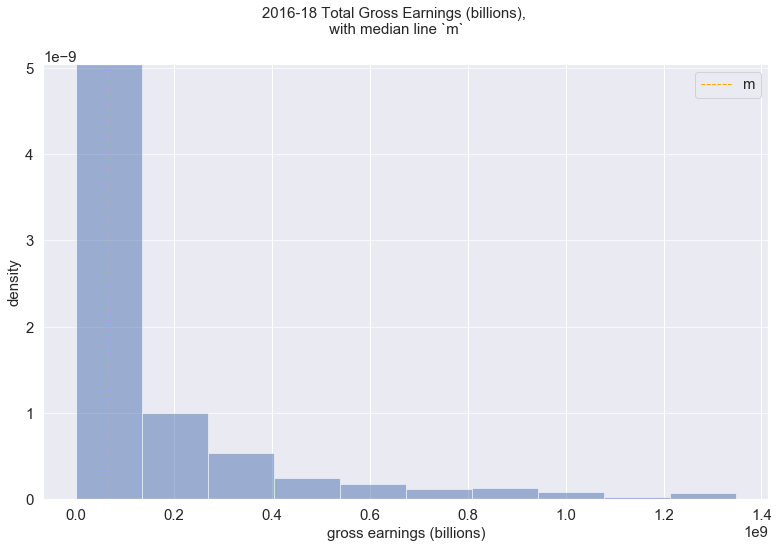

In [74]:
# create a plot
plt.figure(figsize=(13, 8))

# data and number of groupings
plt.hist(bom_2016_18_df.Total_gross, bins=10, density=True, alpha=.5)

# chart appearance
plt.grid(axis='y', alpha=0.75)
plt.xlabel('gross earnings (billions)',fontsize=15)
plt.ylabel('density',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.suptitle("2016-18 Total Gross Earnings (billions),\n with median line `m`", fontsize=15)

plt.axvline(bom_2016_18_df.Total_gross.median(
), color='orange', linestyle='dashed', linewidth=1)

plt.legend("m")

plt.show()

# We can see that most movies perform toward the lower end.

In [75]:
print(f"...bearing-in-mind that most movie (0-2 on the plot) earnings are located about {bom_16_18_title_10_df.Total_gross.median()} (abpve 1B).")

...bearing-in-mind that most movie (0-2 on the plot) earnings are located about 1198050000.0 (abpve 1B).


In [76]:
# There is a lot going on in the middle
total_median_16_18 = bom_2016_18_df.Total_gross.median()
total_std_16_18 = bom_2016_18_df.Total_gross.std()

lower_upper_16_18 = total_median_16_18 + total_std_16_18
upper_lower_16_18 = total_median_16_18 - total_std_16_18

# show first values above median
print("lower upper-middle\n", bom_2016_18_df[(bom_2016_18_df.Total_gross < 
                                             lower_upper_16_18
                                             ) & (bom_2016_18_df.Total_gross > 
                                             total_median_16_18)].tail(3))
# show first values below median
print("-"*80, "\n\nupper lower-middle\n", bom_2016_18_df[bom_2016_18_df.Total_gross <
                                                         total_median_16_18].head(3))

lower upper-middle
       index              title   studio  domestic_gross  foreign_gross  year  \
3157   3162        Love, Simon      Fox      40800000.0     25500000.0  2018   
3158   3163            Mile 22      STX      36100000.0     30200000.0  2018   
3159   3164  Life of the Party  WB (NL)      53100000.0     12800000.0  2018   

      Total_gross  
3157   66300000.0  
3158   66300000.0  
3159   65900000.0  
-------------------------------------------------------------------------------- 

upper lower-middle
       index                                  title studio  domestic_gross  \
2418   2422                          Hail, Caesar!   Uni.      30500000.0   
2419   2423                          The Nice Guys     WB      36300000.0   
2420   2424  L.O.R.D: Legend of Ravaging Dynasties     AR        350000.0   

      foreign_gross  year  Total_gross  
2418     33100000.0  2016   63600000.0  
2419     26500000.0  2016   62800000.0  
2420     57700000.0  2016   58050000.0  


In [77]:
# looking at quantiles in 8 bins to compare mean/ median
q = pd.qcut(bom_2016_18_df.Total_gross, q=8)
q

# finding higer lows and lower highs in the spread of the lower-middle (mean)
# [37900000.0,  64200000.0] and upper middle [64200000.0, 103100000.0]

2318    (381600000.0, 1347000000.0]
2319    (381600000.0, 1347000000.0]
2320    (381600000.0, 1347000000.0]
2321    (381600000.0, 1347000000.0]
2322    (381600000.0, 1347000000.0]
                   ...             
3377                            NaN
3378                            NaN
3379                            NaN
3380                            NaN
3381                            NaN
Name: Total_gross, Length: 1064, dtype: category
Categories (8, interval[float64]): [(38599.999, 6590000.0] < (6590000.0, 17800000.0] < (17800000.0, 37900000.0] < (37900000.0, 64200000.0] < (64200000.0, 103100000.0] < (103100000.0, 184000000.0] < (184000000.0, 381600000.0] < (381600000.0, 1347000000.0]]

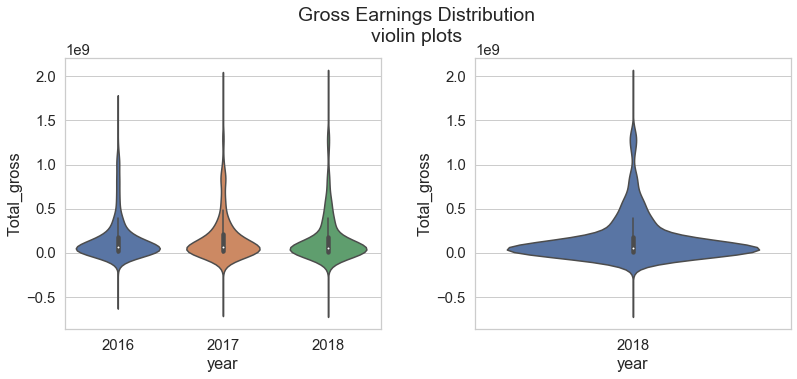

In [78]:
# viewing the three most recent years from the dataset
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
sns.set(context='notebook', font_scale=1.35)

# give a little more space between the 'suptitle' and fiugre
fig.suptitle("Gross Earnings Distribution\nviolin plots", y=1.02)
# and between subplots
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.3, hspace=None)

sns.violinplot(x="year", y="Total_gross", data=bom_2016_18_df, ax=ax[0], cut=8)
sns.violinplot(x="year", y="Total_gross", data=bom_2018_df, ax=ax[1], cut=8)

plt.show()

<h3 align='center'><font color='coral'>Budget</font></h3>

### Now let's take a look at buget information in the `clean_tn_tbl`

In [79]:
cur.execute('''SELECT *
                    FROM clean_tn_tbl
                    WHERE Year BETWEEN 2016 AND 2018
                    ;
                    ''')

tn_df = pd.DataFrame(cur.fetchall())
tn_df.columns = [x[0] for x in cur.description]

In [80]:
# note: sorting will only work if datatypes are appropriately converted
tn_sort_2016_18 = tn_df.sort_values(['worldwide_gross'], ascending=[0])
tn_sort_2016_18.shape, tn_sort_2016_18.head(10)

((506, 9),
     index  id         release_date                              movie  \
 1       6   7  2018-04-27 00:00:00             Avengers: Infinity War   
 9      41  42  2018-02-16 00:00:00                      Black Panther   
 0       4   5  2017-12-15 00:00:00  Star Wars Ep. VIII: The Last Jedi   
 33    112  13  2018-06-22 00:00:00     Jurassic World: Fallen Kingdom   
 37    134  35  2017-03-17 00:00:00               Beauty and the Beast   
 10     43  44  2018-06-15 00:00:00                      Incredibles 2   
 6      22  23  2017-04-14 00:00:00            The Fate of the Furious   
 38    135  36  2018-12-21 00:00:00                            Aquaman   
 4      16  17  2016-05-06 00:00:00         Captain America: Civil War   
 11     44  45  2016-12-16 00:00:00       Rogue One: A Star Wars Story   
 
     production_budget  domestic_gross  worldwide_gross  Year    ROI  
 1         300000000.0     678815482.0     2.048134e+09  2018  85.35  
 9         200000000.0     7000

There appears to be only 506 rows in this table, but they look like a significant 506.

In [81]:
tn_sort_2016_18.dtypes

index                  int64
id                     int64
release_date          object
movie                 object
production_budget    float64
domestic_gross       float64
worldwide_gross      float64
Year                  object
ROI                  float64
dtype: object

### The `tn...` dataframe also enables us to compute net earnings figures.

In [82]:
tn_sort_2016_18['Worldwide_net'] = round(
    tn_sort_2016_18['worldwide_gross'], 3)
- round(tn_sort_2016_18['production_budget'], 3)

W_net_16_18 = tn_sort_2016_18.sort_values(
    by=['Worldwide_net'], ascending=False)
W_net_16_18.head(10)

,index,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Year,ROI,Worldwide_net
1,6,7,2018-04-27 00:00:00,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2018,85.35,2.048134e+09
9,41,42,2018-02-16 00:00:00,Black Panther,200000000.0,700059566.0,1.348258e+09,2018,85.17,1.348258e+09
0,4,5,2017-12-15 00:00:00,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,75.93,1.316722e+09
33,112,13,2018-06-22 00:00:00,Jurassic World: Fallen Kingdom,170000000.0,417719760.0,1.305773e+09,2018,86.98,1.305773e+09
37,134,35,2017-03-17 00:00:00,Beauty and the Beast,160000000.0,504014165.0,1.259200e+09,2017,87.29,1.259200e+09
10,43,44,2018-06-15 00:00:00,Incredibles 2,200000000.0,608581744.0,1.242521e+09,2018,83.90,1.242521e+09
6,22,23,2017-04-14 00:00:00,The Fate of the Furious,250000000.0,225764765.0,1.234846e+09,2017,79.75,1.234846e+09
38,135,36,2018-12-21 00:00:00,Aquaman,160000000.0,335061807.0,1.146895e+09,2018,86.05,1.146895e+09
4,16,17,2016-05-06 00:00:00,Captain America: Civil War,250000000.0,408084349.0,1.140069e+09,2016,78.07,1.140069e+09
11,44,45,2016-12-16 00:00:00,Rogue One: A Star Wars Story,200000000.0,532177324.0,1.049103e+09,2016,80.94,1.049103e+09


A data dictionary could help us to further differentiate earnings discrepancies in the data between these two tables (eg., strictly box office vs all media) as well as providing clearer understanding for when data were collected.

### What can we infer from a cursory visual analysis of `production_budget`, `worldwide_gross`, and `Worldwide_net`

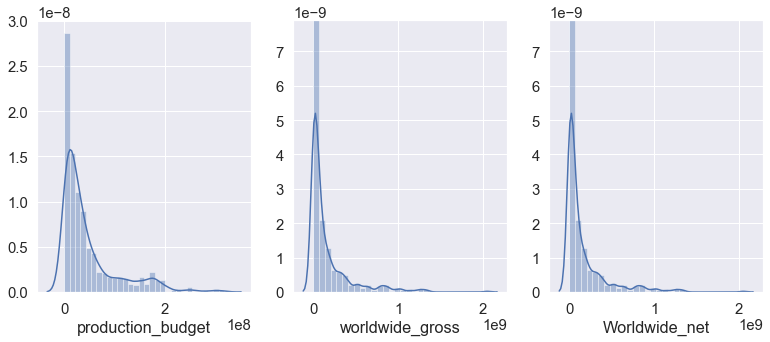

In [83]:
# set a 3 - column axis on a matplotlib figure
fig, ax = plt.subplots(ncols=3, figsize=(13, 5))

# create Seaborn distribution subplots for budget, worldwide gross,
# and worldwide net
sns.distplot(tn_sort_2016_18.production_budget, bins = 30, ax=ax[0])
sns.distplot(tn_sort_2016_18.worldwide_gross, bins = 30
             , ax=ax[1])
sns.distplot(tn_sort_2016_18.Worldwide_net, bins = 30
             , ax=ax[2])

plt.show()


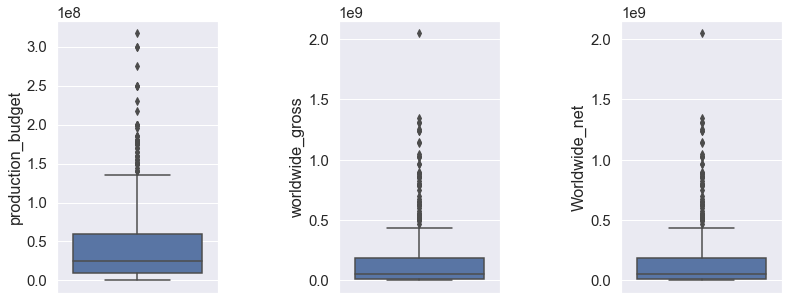

In [84]:
fig, ax = plt.subplots(ncols=3, figsize=(13, 5))
sns.boxplot(tn_sort_2016_18.production_budget, orient='v', ax=ax[0])
sns.boxplot(tn_sort_2016_18.worldwide_gross, orient='v', ax=ax[1])
sns.boxplot(tn_sort_2016_18.Worldwide_net, orient='v', ax=ax[2])
 
plt.subplots_adjust(wspace=.75, hspace=.5);
sns.set(font_scale=1.25)
plt.show()


It seems a few things are generously funded (far above the median), most are well funded (in the upper quartile), and relatively high net profit is rare thing.

In [85]:
print("Middle Quantile Budget: ", tn_sort_2016_18.production_budget.quantile(.5), "        Middle Quantile Worldwide Gross: ", tn_sort_2016_18.worldwide_gross.quantile(.5))
print("Middle Quantile Net:    ", tn_sort_2016_18.Worldwide_net.quantile(.5))

Middle Quantile Budget:  25000000.0         Middle Quantile Worldwide Gross:  55674516.0
Middle Quantile Net:     55674516.0


<h2 align='center'><font color='chocolate'>Correlation</font></h2>

<h3>Question(s)</h3>

* Are gross and net figures positively correlated
* ... Budget and ROI

These points can help eliminate redundancy in our analysis. If correlation is strong between gross and net data, for example, then we can explore one to make inferences about the other.

<h3 align='center'><font color='coral'>gross, net</font></h3>

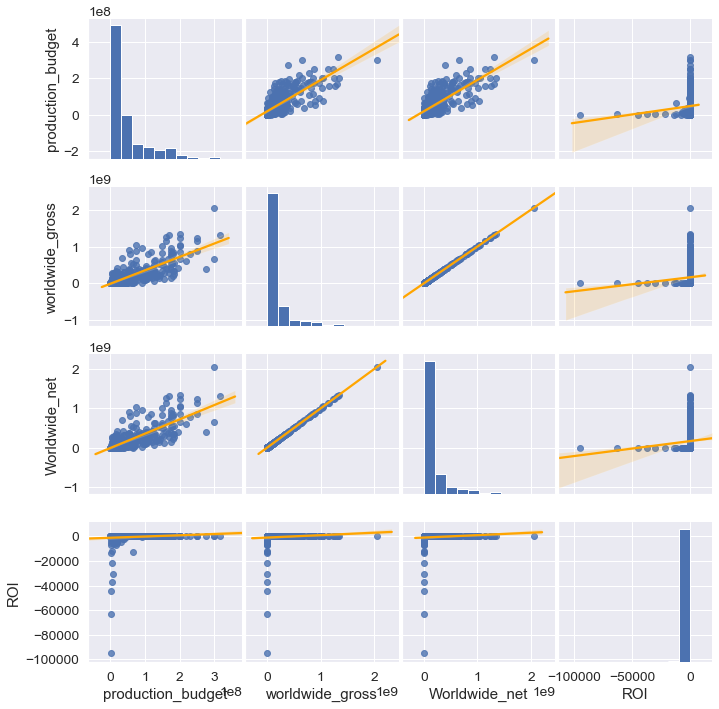

In [86]:
# view a seaborn pairplot matrix with regression lines
df1 = tn_sort_2016_18[["production_budget", "worldwide_gross",
                     "Worldwide_net", "ROI"]]
sns.pairplot(df1, kind="reg", plot_kws={'line_kws':{'color':'orange'}})
sns.set(font_scale=.8) # try to prevent overlap of long column names
plt.subplots_adjust(wspace=.02, hspace=.2);
plt.show()

We see from the visualizations that there are strong, positive correlations between budget and gross earnings.

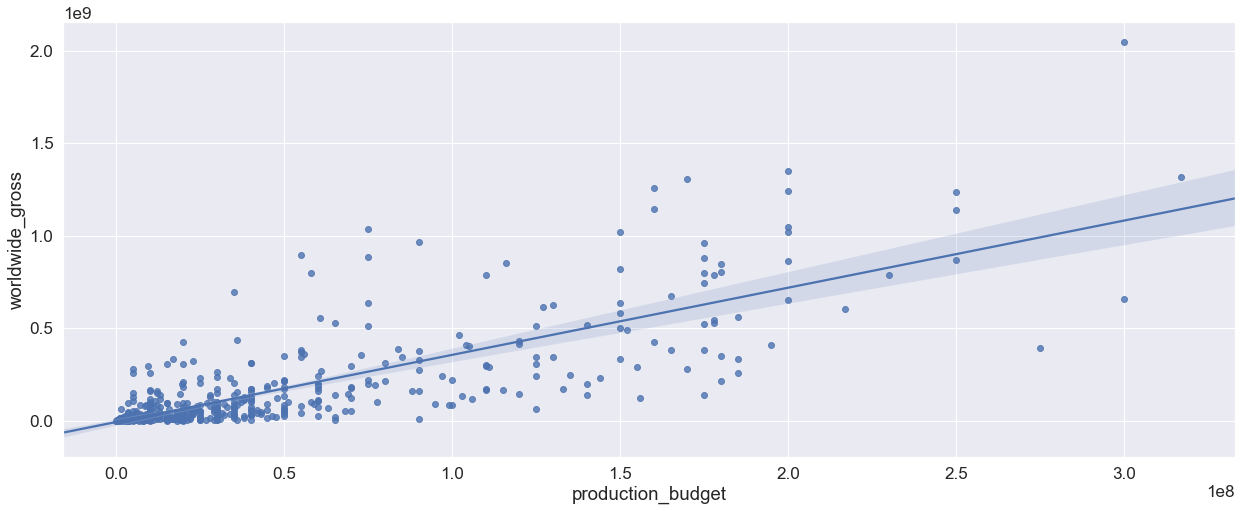

In [87]:
# create a variable for the correlation
corr = df1.corr()

# subplots
plt.figure(figsize=(21, 8)) # total figure size

plt.subplots_adjust(wspace=.35, hspace=.1); # prevent overlap
sns.set(font_scale=1.55) # adjust for annotation legibility

plt.subplot(1,1,1) # correlation with regression line
sns.regplot(x='production_budget', y='worldwide_gross', data=df1)

plt.show()

### The relationship between budget and ROI seems a bit more complex.

In [88]:
t = tn_sort_2016_18

t_gross_below_mean = t.loc[t['worldwide_gross'] < t['worldwide_gross'].mean()]
t_gross_above_mean = t.loc[t['worldwide_gross'] > t['worldwide_gross'].mean()]

Correlation for earnings below the mean: 0.10529470398617378 ; and above the mean: -0.4320160441549467


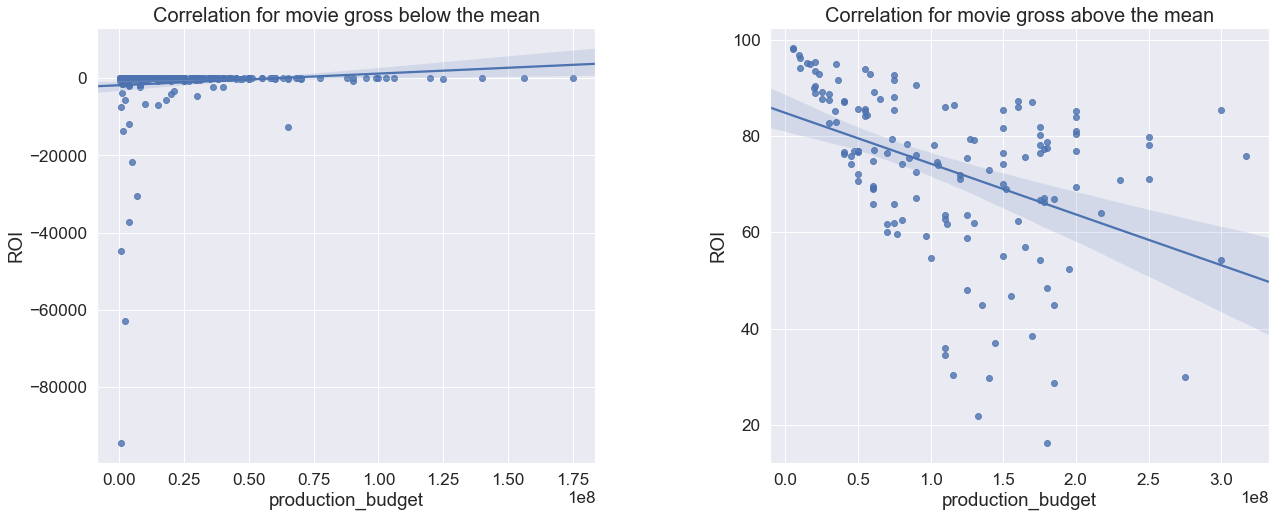

In [89]:
t1 = t_gross_below_mean
t2 = t_gross_above_mean

print("Correlation for earnings below the mean:"
      , t1.production_budget.corr(t1.ROI)
      , "; and above the mean:", 
      t2.production_budget.corr(t2.ROI))

# subplots
plt.figure(figsize=(21, 8)) # total figure size
plt.subplots_adjust(wspace=.35, hspace=.1); # prevent overlap
sns.set(font_scale=1.55) # adjust for annotation legibility

plt.subplot(1,2,1) # correlation with regression line
plt.title("Correlation for movie gross below the mean", fontsize=20)
sns.regplot(x='production_budget', y='ROI', data=t1)

plt.subplot(1,2,2) # correlation with regression line
plt.title("Correlation for movie gross above the mean", fontsize=20)
sns.regplot(x='production_budget', y='ROI', data=t2)

plt.show()

We can delve further into whether budget spend is predictive, as we move on to take a look at top studios in the industry.

In [90]:
cur.close()
conn.close()

##### movies-q2 notebook
***

<a id='Question_2'></a>
* [Jump to Data Conditioning](#Data_Conditioning)<br />
* [Jump to Clean and Transform](#Clean_and_Transform)<br />
* [Jump to Question_1](#Question_1)<br />
* [Jump to Question 3](#Question_3)

<h1>Question 2 - Which studios do our data indicate are the highest - earning?</h1>

    1. Which are the top studios in 2018? ...2016-18?
    2. Are any studios trending one way or another?
    3. What are their top grossing titles from these studios?

### importing required libraries

In [91]:
import os # for setting the current directory

import numpy as np
import pandas as pd

import sqlite3
import pandasql

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [92]:
# setting the current working directory
os.chdir("c:/users/jd/flatiron/project01/dsc-mod-1-project-v2-1-online-ds-ft-120919/")

# printing the current working directory
print(os.getcwd())

c:\users\jd\flatiron\project01\dsc-mod-1-project-v2-1-online-ds-ft-120919


### Connecting to sqlite database

In [93]:
# connecting to sql movies_db data source and instantiate a cursor
conn = sqlite3.connect("movies_db.sqlite")
cur = conn.cursor()

### listing the sqlite table names

In [94]:
# getting names of all tables in the sql database
sql_tables = conn.execute("select name from sqlite_master where type='table';")

# assigning table names to a variable as a list for future iteration
table_list = list(map(lambda x: x[0], sql_tables.fetchall()))
table_list

['studio_titles_tbl', 'clean_bom_tbl', 'clean_tn_tbl', 'clean_imdb_title_tbl']

***

<h2 align='center'><font color='chocolate'>Highest grossing studios</font></h2>

We can find studio, title, and worldwide gross in the `clean_bom_tbl`.

### Query sqlite3 to view `clean_bom_tbl` by studio, in order of highest total gross, from 2016-2018.

In [95]:
# connecting to the required table
cur.execute('''SELECT studio, count(title) as num_Titles, sum(Total_gross) as sum_Gross
                    FROM clean_bom_tbl
                    WHERE year BETWEEN 2016 AND 2018
                    GROUP BY studio
                    ORDER BY Total_gross DESC
                    LIMIT 10
                    ;''')

studio_title_count_df = pd.DataFrame(cur.fetchall())
studio_title_count_df.columns = [x[0] for x in cur.description]

print(studio_title_count_df.shape)
studio_title_count_df.sort_values(by='sum_Gross', ascending=False)

(10, 3)


,studio,num_Titles,sum_Gross
0,BV,31,1.925650e+10
2,WB,42,1.281100e+10
1,Uni.,50,1.227112e+10
4,Fox,41,1.051733e+10
5,Sony,46,7.818804e+09
8,Par.,35,5.274600e+09
9,WB (NL),18,3.372700e+09
6,LG/S,17,2.018230e+09
3,HC,1,8.703000e+08
7,FR,8,3.943438e+08


In [96]:
# cleaning those titles using the df.apply() function on `studio` column 
studio_title_count_df['studio'] = studio_title_count_df[
    'studio'].apply(lambda x : x.strip().lower(
).replace(".", "").replace("\(", "").replace("\)", "").replace("\/", ""))

studio_title_count_df.studio

0         bv
1        uni
2         wb
3         hc
4        fox
5       sony
6       lg/s
7         fr
8        par
9    wb (nl)
Name: studio, dtype: object

doing the same for 2018.

In [97]:
# connect to the required table
cur.execute('''SELECT studio, count(title) as num_Titles, sum(Total_gross) as sum_Gross
                    FROM clean_bom_tbl
                    WHERE year == 2018
                    GROUP BY studio
                    ORDER BY Total_gross DESC
                    LIMIT 10
                    ;''')

studio_title_count_2018_df = pd.DataFrame(cur.fetchall())
studio_title_count_2018_df.columns = [x[0] for x in cur.description]

print(studio_title_count_2018_df.shape)
studio_title_count_2018_df.sort_values(by='sum_Gross', ascending=False)

(10, 3)


,studio,num_Titles,sum_Gross
5,BV,10,5.667401e+09
1,WB,17,5.494300e+09
0,Uni.,21,4.900200e+09
3,Sony,15,2.615626e+09
2,Fox,11,2.583500e+09
4,Par.,8,1.886200e+09
7,WB (NL),5,1.055300e+09
8,LGF,12,8.033914e+08
6,WGUSA,8,7.957380e+08
9,MGM,2,2.140000e+08


In [98]:
# cleaning these studio names, as above

studio_title_count_2018_df['studio'] = studio_title_count_2018_df[
    'studio'].apply(lambda x : x.strip().lower(
).replace(".", "").replace("\(", "").replace("\)", "").replace("\/", ""))

studio_title_count_2018_df.studio

0        uni
1         wb
2        fox
3       sony
4        par
5         bv
6      wgusa
7    wb (nl)
8        lgf
9        mgm
Name: studio, dtype: object

***

<h2 align='center'><font color='coral'>Visual EDA: Top Studios</font></h2>

### Plot the Data from the two dataframes as on a single figure.

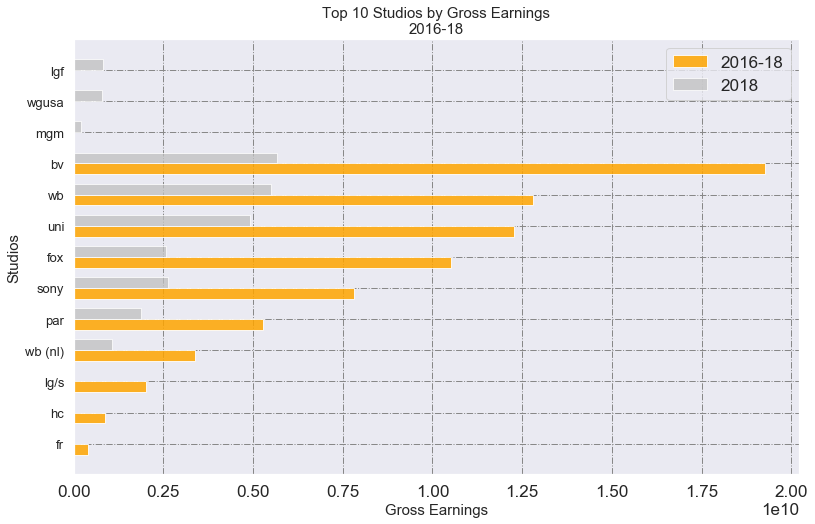

In [99]:
# creating variables for our tables
df_sorted = studio_title_count_df.sort_values(by='sum_Gross',ascending=True)
df_sort_18 = studio_title_count_2018_df.sort_values(by='sum_Gross',ascending=True)

# defining axes
x1 = df_sorted.studio
y1 = df_sorted.sum_Gross
x2 = df_sort_18.studio
y2 = df_sort_18.sum_Gross

# creating the figure
plt.figure(figsize=(13,8))
width = 0.35       # the width of the bars
plt.grid(b=True, which='major', color='#888888', linestyle='-.')
plt.barh(x1, y1, -width, color='orange', align='edge', alpha=.85,  label = '2016-18')
plt.barh(x2, y2, +width, color='silver', align='edge', alpha=.75,  label = '2018')

# defining labels
plt.ylabel('Studios', fontsize=15)
plt.yticks(fontsize=13)
plt.xlabel('Gross Earnings', fontsize=15)
plt.title("Top 10 Studios by Gross Earnings\n2016-18", fontsize=15)

plt.legend()
plt.show()

The top 6 studios of 2018, by gross, were also the top 6 for 2016-2018.

<h2 align='center'><font color='coral'>Top Titles from Highest grossing studios</font></h2>

### Getting a dataframe with titles (not just counts)


In [100]:
# connecting to the required table
cur.execute('''SELECT studio, title, Total_gross
                    FROM clean_bom_tbl
                    WHERE year BETWEEN 2016 AND 2018
                    ORDER BY Total_gross DESC
                    ;''')

studio_titles_df = pd.DataFrame(cur.fetchall())
studio_titles_df.columns = [x[0] for x in cur.description]

### Getting studio names

In [101]:
# must go back to clean these in sqlite3
studio_titles_df['studio'] = studio_titles_df[
    'studio'].apply(lambda x : x.strip().lower(
).replace(".", "").replace("\(", "").replace("\)", "").replace("\/", ""))

print(studio_titles_df.shape)
studio_titles_df.head(2)

(1064, 3)


,studio,title,Total_gross
0,bv,Black Panther,1.347000e+09
1,bv,Star Wars: The Last Jedi,1.332600e+09


In [102]:
# getting the studio names

# storing dtype before operation 
dtype_before = type(studio_title_count_df["studio"]) 
  
# converting to list 
studio_list = studio_title_count_df["studio"].head(6).tolist() 
  
# storing dtype after operation 
dtype_after = type(studio_list) 
  
# printing dtype 
print("Data type before converting = {}\nData type after converting = {}"
      .format(dtype_before, dtype_after)) 
  
# displaying list 
studio_list 

Data type before converting = <class 'pandas.core.series.Series'>
Data type after converting = <class 'list'>


['bv', 'uni', 'wb', 'hc', 'fox', 'sony']

### Slice dataframes for the top-6 studios from the 2016-18 dataframe, to view their top titles.

In [103]:
# test one
df = studio_titles_df[studio_titles_df['studio'] == 'uni'].head(10)
df

,studio,title,Total_gross
2,uni,Jurassic World: Fallen Kingdom,1.309500e+09
8,uni,Despicable Me 3,1.034800e+09
15,uni,The Secret Life of Pets,8.755000e+08
35,uni,Sing,6.342000e+08
51,uni,Dr. Seuss' The Grinch (2018),5.116000e+08
57,uni,Warcraft,4.337000e+08
59,uni,Jason Bourne,4.155000e+08
61,uni,The Mummy (2017),4.092000e+08
63,uni,Mamma Mia! Here We Go Again,3.950000e+08
68,uni,Fifty Shades Darker,3.816000e+08



------------------------------------------------------------------
<h2 align='center'><font color='coral'>Visualization</font></h2>

#### Visualizing top-10 titles from each of the top studios

In [104]:
# entering studios argument as a list of one or more
def get_studio_10(studios):
    for target in studios:
        df = studio_titles_df[studio_titles_df['studio'] == target].head(10)
        display(df)

In [105]:
# using a loop
get_studio_10(['bv'])

,studio,title,Total_gross
0,bv,Black Panther,1.347000e+09
1,bv,Star Wars: The Last Jedi,1.332600e+09
3,bv,Beauty and the Beast (2017),1.263500e+09
4,bv,Incredibles 2,1.242800e+09
5,bv,Captain America: Civil War,1.153300e+09
7,bv,Rogue One: A Star Wars Story,1.056100e+09
9,bv,Finding Dory,1.028600e+09
10,bv,Zootopia,1.023800e+09
11,bv,The Jungle Book (2016),9.665000e+08
18,bv,Guardians of the Galaxy Vol. 2,8.637000e+08


In [106]:
def get_studio_10_barh(studios):
    for target in studios:
        df = studio_titles_df[studio_titles_df['studio'] == target].head(10)
        
        # defining axes
        x = df.title
        y = df.Total_gross

        # creating the figure
        plt.figure(figsize=(8, 5))
        width = 0.35       # the width of the bars
        plt.grid(b=True, which='minor', color='#888888', linestyle='--')
        plt.barh(x, y, -width, color='orange', align='edge', alpha=.85,  label = '2016-18')
        plt.ylim(plt.ylim()[::-1])

        # defining labels
        plt.ylabel('Titles', fontsize=15)
        plt.yticks(fontsize=13)
        plt.xlabel('Gross Earnings', fontsize=15)
        plt.title(f'Top 10 Titles from {target}, 2016-18', fontsize=15)

        plt.legend()
        plt.show()

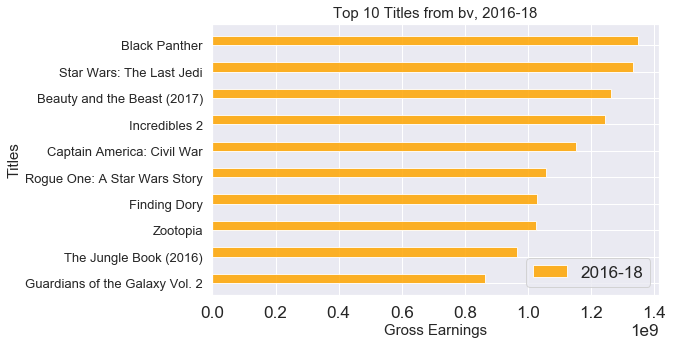

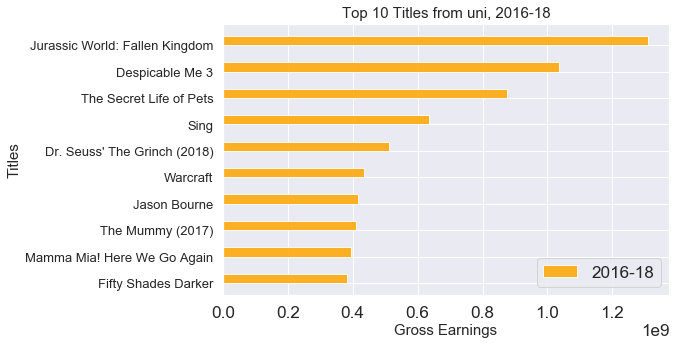

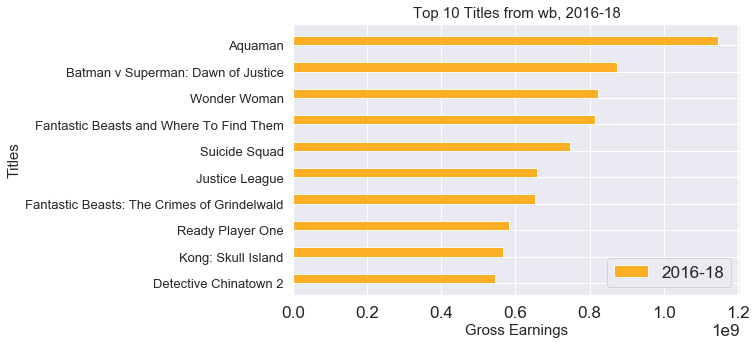

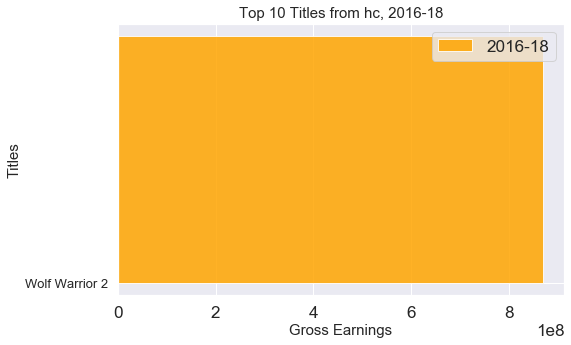

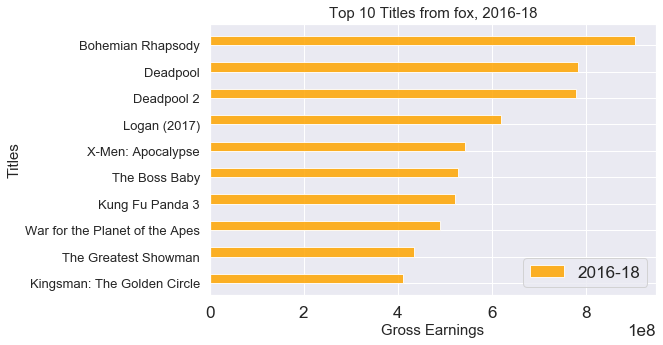

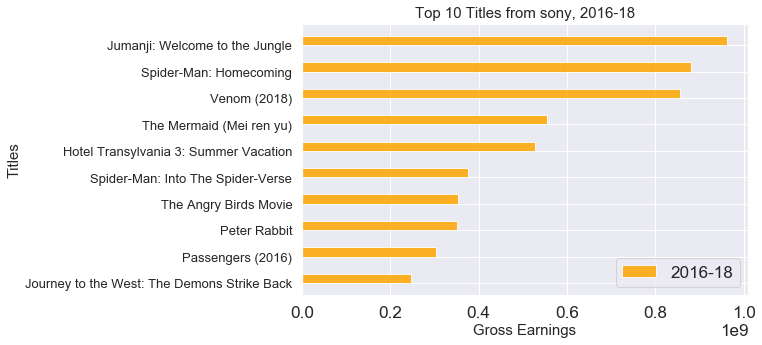

In [107]:
# using `studio_list` to view all studios
get_studio_10_barh(studio_list)

***

### Adding `studio_titles_df` to sqlite

Saving this useful table for genre exploration

In [108]:
# add the new df as a table to the sqlite database
studio_titles_df.to_sql('studio_titles_tbl', conn, if_exists='replace')

### list the sqlite table names

In [109]:
# viewing names of all tables in the sql database to verify operation
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('clean_bom_tbl',),
 ('clean_tn_tbl',),
 ('clean_imdb_title_tbl',),
 ('studio_titles_tbl',)]

In [110]:
cur.close()
conn.close()

* We observe Buena Vista far ahead of the pack, in recent years. Much of this is owed to action adventure fantasy sequels, from the Marvel Cinematic Universe and the Star Wars franchise. However, there are a couple of surprises, including the one-off, animated feature Zootopia.
* It is also of note that Sony makes the top-10. The company's second - highest grossing movie between 2016-2018 was produced under license by The Walt Disney Company's (BV) Marvel Studios.
* There are many enticing avenues to explore with additional data.

##### movies-q3 notebook
***

<a id='Question_3'></a>
* [Jump to Data Conditioning](#Data_Conditioning)<br />
* [Jump to Clean and Transform](#Clean_and_Transform)<br />
* [Jump to Question 1](#Question_1)
* [Jump to Question_2](#Question_2)<br />

<h1>Question 3 - What genres have been the most lucrative?</h1>

    1. What genres appear most frequently?
    2. Which earned the most in 2018? ...2016-18?
    3. What mix of genres do top studios use?

### importing required libraries

In [111]:
import os # for setting the current directory

import numpy as np
import pandas as pd

import sqlite3
import pandasql

import matplotlib.pyplot as plt
%matplotlib inline


In [112]:
# setting the current working directory
os.chdir("c:/users/jd/flatiron/project01/dsc-mod-1-project-v2-1-online-ds-ft-120919/")

# printing the current working directory
print(os.getcwd())

c:\users\jd\flatiron\project01\dsc-mod-1-project-v2-1-online-ds-ft-120919


### Connecting to sqlite database

In [113]:
# connecting to sql movies_db data source and instantiate a cursor
conn = sqlite3.connect("movies_db.sqlite")
cur = conn.cursor()

### listing the sqlite table names

In [114]:
# getting names of all tables in the sql database
sql_tables = conn.execute("select name from sqlite_master where type='table';")

# assigning table names to a variable as a list for future iteration
table_list = list(map(lambda x: x[0], sql_tables.fetchall()))
table_list

['clean_bom_tbl', 'clean_tn_tbl', 'clean_imdb_title_tbl', 'studio_titles_tbl']

***

<h2 align='center'><font color='chocolate'>Genres</font></h2>

We can find titles with their genres in the `clean_imdb_title_tbl`.

### Querying sqlite3 to view `clean_imdb_title_tbl`

In [115]:
# connecting to the required table as a temporary table
# using temporary table to inspect data
cur.execute('''SELECT *
                    FROM clean_imdb_title_tbl
                    WHERE start_year BETWEEN 2016 AND 2018
                    ;''')

data_df = pd.DataFrame(cur.fetchall())
data_df.columns = [x[0] for x in cur.description]

print(data_df.shape)
data_df.head(3)

(51625, 34)


,index,tconst,primary_title,original_title,start_year,runtime_minutes,genres,family,music,crime,talk-show,reality-tv,comedy,western,documentary,history,fantasy,sci-fi,sport,mystery,adventure,musical,animation,drama,short,adult,romance,action,war,news,thriller,biography,game-show,horror
0,2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Dropping columns and rows

In [116]:
# deleting all rows where column `genres` has value 'None' 
print("Starting count of empty 'genres':", data_df.genres.isnull().sum())
data_df = data_df[data_df['genres'].notnull()]
print("Ending count of empty 'genres':", data_df.genres.isnull().sum())

Starting count of empty 'genres': 2163
Ending count of empty 'genres': 0


In [117]:
# removing unnecessary columns
data_df.drop(columns = ['index', 'original_title', 'runtime_minutes'])

# setting the index
data_df.set_index("tconst", inplace=True)

In [118]:
# copying to our separate, working dataframe
clean_imdb_title_df = data_df.copy(deep=True)

print(clean_imdb_title_df.shape)

# verifying removal of rows with no genres
clean_imdb_title_df[clean_imdb_title_df['genres'].isnull() == True]

(49462, 33)


,index,primary_title,original_title,start_year,runtime_minutes,genres,family,music,crime,talk-show,reality-tv,comedy,western,documentary,history,fantasy,sci-fi,sport,mystery,adventure,musical,animation,drama,short,adult,romance,action,war,news,thriller,biography,game-show,horror
tconst,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


No rows without genres remain.

In [119]:
# updated df changes to the sqlite database table
clean_imdb_title_df.to_sql('clean_imdb_title_tbl', conn, if_exists='replace')

<h2 align='center'><font color='coral'>Counting Genres</font></h2>

### Counting the occurrences of any individual genre

In [120]:
# shortening the dataframe name
df0 = clean_imdb_title_df

In [121]:
# counting the number of True boolean markers (1s) indicated in the `drama` column/ series
len(df0[df0['drama'] == 1])

16834

In [122]:
# verify our count of the value 1s in the `drama` column
df0['drama'].value_counts()

0    32628
1    16834
Name: drama, dtype: int64

In [123]:
# making a list of all genre column names
genre_names = [col for col in df0.columns[6:]]

# an equal - length list of all genre counts for value 1
genre_counts = [len(df0[df0[g] == 1]) for g in genre_names]

# bringing the two lists together as tuples
genre_tuples_list = list(zip(genre_names, genre_counts))

# viewing the list of tuples
genre_tuples_list

[('family', 1738),
 ('music', 1620),
 ('crime', 2366),
 ('talk-show', 17),
 ('reality-tv', 45),
 ('comedy', 8478),
 ('western', 153),
 ('documentary', 17501),
 ('history', 1523),
 ('fantasy', 1278),
 ('sci-fi', 1192),
 ('sport', 709),
 ('mystery', 1665),
 ('adventure', 1995),
 ('musical', 492),
 ('animation', 975),
 ('drama', 16834),
 ('short', 9),
 ('adult', 18),
 ('romance', 3032),
 ('action', 3592),
 ('war', 468),
 ('news', 125),
 ('thriller', 4252),
 ('biography', 2154),
 ('game-show', 2),
 ('horror', 3964)]

#### Converting the list to a dataframe and visualizing

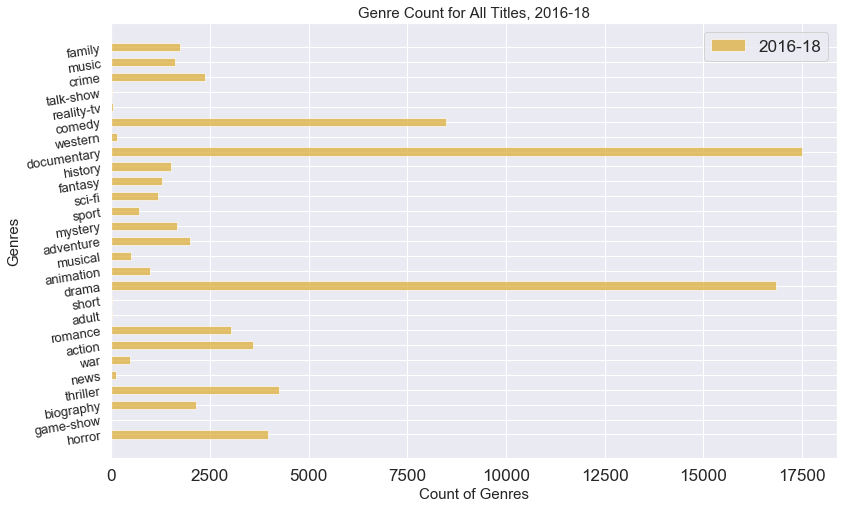

In [124]:

genre_counts_df = pd.DataFrame(genre_tuples_list, columns = ['genre_names' , 'genre_counts'])
gcdf = genre_counts_df

# defining axes
x = gcdf.genre_names
y = gcdf.genre_counts

# creating the figure
plt.figure(figsize=(13, 8))
width = 0.55       # the width of the bars
plt.grid(b=True, which='minor', color='#888888', linestyle='-.')
plt.barh(x, y, -width, color='goldenrod', align='center', alpha=.65,  label = '2016-18')
plt.ylim(plt.ylim()[::-1])

# defining labels
plt.ylabel('Genres', fontsize=15)
plt.yticks(fontsize=13, rotation=9)
plt.xlabel('Count of Genres', fontsize=15)
plt.title(f'Genre Count for All Titles, 2016-18', fontsize=15)

plt.legend()
plt.show()


From this vizualization, it looks like a runaway for documentaries. Of course, we want to look at earnings for these genres.

We already have a table for title, studio, and total gross, for movies released between 2016-18.

### Import and Join

In [125]:
# connecting to the required table
cur.execute('''SELECT *
                    FROM studio_titles_tbl s
                    JOIN clean_imdb_title_tbl c
                    ON s.title = c.primary_title
                    ;''')

joined_studio_genres_df = pd.DataFrame(cur.fetchall())
joined_studio_genres_df.columns = [x[0] for x in cur.description]
display(joined_studio_genres_df.shape)
joined_studio_genres_df.head()

(806, 38)

,index,studio,title,Total_gross,tconst,index,primary_title,original_title,start_year,runtime_minutes,genres,family,music,crime,talk-show,reality-tv,comedy,western,documentary,history,fantasy,sci-fi,sport,mystery,adventure,musical,animation,drama,short,adult,romance,action,war,news,thriller,biography,game-show,horror
0,0,bv,Black Panther,1.347000e+09,tt1825683,19050,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,bv,Star Wars: The Last Jedi,1.332600e+09,tt2527336,42223,Star Wars: The Last Jedi,Star Wars: Episode VIII - The Last Jedi,2017,152.0,"Action,Adventure,Fantasy",0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,uni,Jurassic World: Fallen Kingdom,1.309500e+09,tt4881806,84414,Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,2018,128.0,"Action,Adventure,Sci-Fi",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,bv,Incredibles 2,1.242800e+09,tt3606756,62741,Incredibles 2,Incredibles 2,2018,118.0,"Action,Adventure,Animation",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,5,bv,Captain America: Civil War,1.153300e+09,tt3498820,60379,Captain America: Civil War,Captain America: Civil War,2016,147.0,"Action,Adventure,Sci-Fi",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


Limiting films by those with stated genres took 258 rows off of the `studio_titles` table. Limiting titles to those from our 6 top studios removed almost 32000 rows.

In [126]:
# dropping unneeded columns
jsg = joined_studio_genres_df.drop(columns = ['index', 'tconst', 'original_title', 'runtime_minutes'])

# setting the index
jsg.set_index("title", inplace=True)
display(jsg.shape)

pd.set_option('display.max_columns', None) # expand to inspect all columns
jsg.head()

(806, 32)

,studio,Total_gross,primary_title,start_year,genres,family,music,crime,talk-show,reality-tv,comedy,western,documentary,history,fantasy,sci-fi,sport,mystery,adventure,musical,animation,drama,short,adult,romance,action,war,news,thriller,biography,game-show,horror
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Black Panther,bv,1.347000e+09,Black Panther,2018,"Action,Adventure,Sci-Fi",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
Star Wars: The Last Jedi,bv,1.332600e+09,Star Wars: The Last Jedi,2017,"Action,Adventure,Fantasy",0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
Jurassic World: Fallen Kingdom,uni,1.309500e+09,Jurassic World: Fallen Kingdom,2018,"Action,Adventure,Sci-Fi",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
Incredibles 2,bv,1.242800e+09,Incredibles 2,2018,"Action,Adventure,Animation",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
Captain America: Civil War,bv,1.153300e+09,Captain America: Civil War,2016,"Action,Adventure,Sci-Fi",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


***

<h2 align='center'><font color='coral'>Earnings by Genre</font></h2>

### How much money does each genre make for top studios?

In [127]:
# getting the sum of `Total_gross` where `drama` is equal to 1 
jsg[jsg['drama'] == 1]['Total_gross'].sum()

20506547200.0

In [128]:
# repeating for 2018, only
jsg[(jsg['drama'] == 1) & (jsg['start_year'] == 2018)]['Total_gross'].sum()

5125591500.0

### Building the tuple list for 2016-2018

In [129]:
# using our list of all genre column names 'genre_names'
# genre_names = [col for col in jsg.columns[6:]]

# an equal - length list of all genre `Total_gross` sums value 1
genre_gross = [jsg[jsg[g] == 1]['Total_gross'].sum() for g in genre_names]
genre_gross_18 = [jsg[(jsg[g] == 1) & (jsg['start_year'] == 2018)]['Total_gross'
                                                       ].sum() for g in genre_names]

# bringing the two lists together as tuples
genre_gross_tuples = list(zip(genre_names, genre_gross))
genre_gross_tuples_18 = list(zip(genre_names, genre_gross_18))

#### Converting the list to a dataframe and visualizing

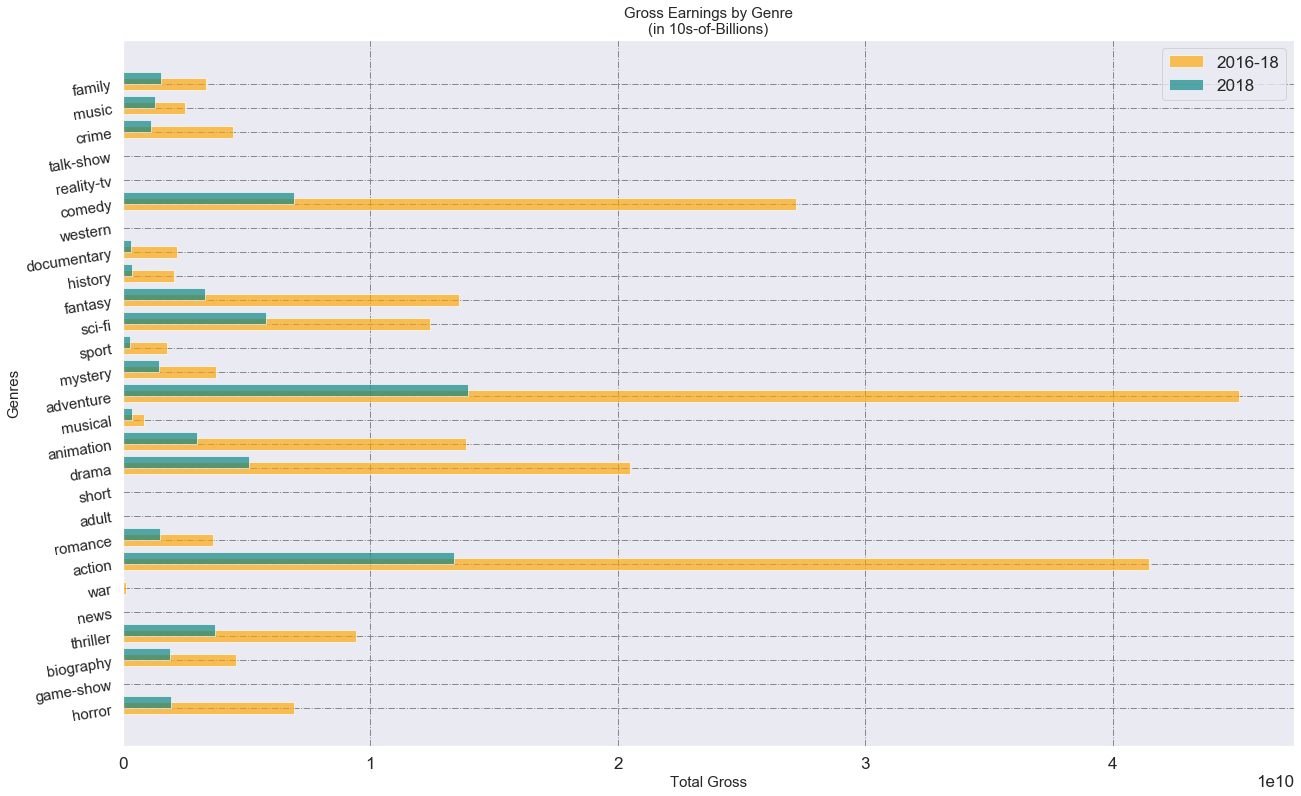

In [130]:
# converting list of tuples to dataframe
ggt = pd.DataFrame(genre_gross_tuples, columns = ['genre_names' , 'genre_gross'])
ggt18 = pd.DataFrame(genre_gross_tuples_18, columns = ['genre_names' , 'genre_gross_18'])

# defining axes
x1 = ggt.genre_names
x2 = ggt18.genre_names
y1 = ggt.genre_gross
y2 = ggt18.genre_gross_18

# creating the figure
plt.figure(figsize=(21, 13))
width = 0.5       # the width of the bars
plt.grid(b=True, which='major', color='#888888', linestyle='-.')
plt.minorticks_on()
plt.barh(x1, y1, width, color='orange', align='center', alpha=.65,  label = '2016-18')
plt.barh(x2, y2, -width, color='teal', align='edge', alpha=.65,  label = '2018')

plt.ylim(plt.ylim()[::-1])

# defining labels
plt.ylabel('Genres', fontsize=15)
plt.yticks(fontsize=15, rotation=9)
plt.xlabel('Total Gross', fontsize=15)
plt.title(f'Gross Earnings by Genre\n(in 10s-of-Billions)', fontsize=15)

plt.legend()
plt.show()


Adventure, action, and comedy take on significance, when the focus is placed on earnings. How do studios balance that.

### What genres of movies are most often used in top - studio productions?

In [131]:
# using our list of all genre column names 'genre_names'
# genre_names = [col for col in jsg.columns[6:]]

# an equal - length list of all genre counts for value 1
freq_counts = [len(jsg[jsg[g] == 1]) for g in genre_names]
freq_counts_18 = [len((jsg[(jsg[g] == 1
                           ) & (jsg['start_year'] == 2018
                               )]
                      )
                     ) for g in genre_names]

# bringing the lists together as tuples
studio_top_gen_freq = list(zip(genre_names, freq_counts))
studio_top_gen_freq_18 = list(zip(genre_names, freq_counts_18))


#### Converting the list to a dataframe and visualizing

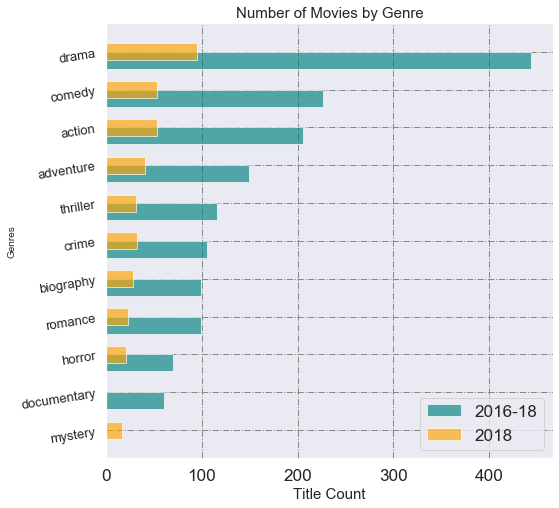

In [132]:
# limiting output to the top - ten for each analysis period
stgf = pd.DataFrame(studio_top_gen_freq, columns = ['genre_names' , 'freq_counts']
                   ).sort_values(by='freq_counts', ascending=False).head(10)
stgf_18 = pd.DataFrame(studio_top_gen_freq_18, columns = ['genre_names' , 'freq_counts_18']
                      ).sort_values(by='freq_counts_18', ascending=False).head(10)

# defining axes
x1 = stgf.genre_names
x2 = stgf_18.genre_names
y1 = stgf.freq_counts
y2 = stgf_18.freq_counts_18

# creating the figure
plt.figure(figsize=(8, 8))
width = 0.45       # the width of the bars
plt.grid(b=True, which='major', color='#888888', linestyle='-.')
plt.minorticks_on()
plt.barh(x1, y1, width, color='teal', align='edge', alpha=.65,  label = '2016-18')
plt.barh(x2, y2, -width, color='orange', align='center', alpha=.65,  label = '2018')
plt.ylim(plt.ylim()[::-1])

# defining labels
plt.ylabel('Genres', fontsize=10)
plt.yticks(fontsize=13, rotation=9)
plt.xlabel('Title Count', fontsize=15)
plt.title(f'Number of Movies by Genre', fontsize=15)

plt.legend()
plt.show()


Documentaries are not nearly as prevalent a genre among top studios. It may be interesting to compare single - genre titles to mixed - genre titles, to see whether more nuanced categorization within genres has any positive impact on earnings.

***

<h2 align='center'><font color='Coral'>Recommendations</font></h2>

***

There seems to be a formula at work, in the movie business. The ratio of genres produced by top studios seems to have remained fairly constant. We can verify that by analyzing more closely central tendencies of top studios, including budget - spend and peak release cycles by genre.

Of course, there were a number of tables we did not yet explore. A more comprehensive reviews database could be valuable. Current resources do not indicate which reviews were provided prior to home release, or when income was generated, facts which make them less useful to predictive investigation but which may be resolved through feature engineering.

We do see a strong and rewarded showing by sequels, series, and fantasy (whether live - action, animated, or computer - generated. This is good news, for an industry that is currently increasing its footprint across platforms, from theaters and festivals to streaming services.

Adventure, action, comedy, and drama seem to be the ways to go. ROI consideration could be informative. It takes a lot of budget to make a blockbuster, but there do seem to be sweet spots where a relatively modest investment is more likely than not to result in a comfortable return.

For big swings, we need to determine how to deal with outliers. Many of the movies that made the most cost the most.

In [133]:
cur.close()
conn.close()